# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from albumentations import Compose, ShiftScaleRotate, Blur
from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2
from albumentations.pytorch import ToTensorV2
import copy
from tqdm import tqdm
from matplotlib.pyplot import figure
from torch.utils.data import DataLoader, Dataset

In [ ]:
def make_report(y_pred , y_true, fig_size = (20,20)):
    print ("")
    print ("Classification Report: ")
    print (classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plot_confusion_matrix(figsize=fig_size, conf_mat=cm)
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Load the train.pickle file
with open('train.pickle', 'rb') as f:
    train_data = pickle.load(f)

# Access the features and labels in train_data dictionary
train_features = train_data['features']
train_labels = train_data['labels']

# Load the valid.pickle file
with open('valid.pickle', 'rb') as f:
    valid_data = pickle.load(f)

# Access the features and labels in valid_data dictionary
valid_features = valid_data['features']
valid_labels = valid_data['labels']

# Load the test.pickle file
with open('test.pickle', 'rb') as f:
    test_data = pickle.load(f)

# Access the features and labels in test_data dictionary
test_features = test_data['features']
test_labels = test_data['labels']

# Load the label_names.csv file
label_names = pd.read_csv('label_names.csv')

# Print some sample information
print('Train data shape:', train_features.shape)
print('Number of train labels:', len(train_labels))
print('Valid data shape:', valid_features.shape)
print('Number of valid labels:', len(valid_labels))
print('Test data shape:', test_features.shape)
print('Number of test labels:', len(test_labels))
print('Label names:')
print(label_names)


Train data shape: (34799, 32, 32, 3)
Number of train labels: 34799
Valid data shape: (4410, 32, 32, 3)
Number of valid labels: 4410
Test data shape: (12630, 32, 32, 3)
Number of test labels: 12630
Label names:
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-

# Implement a decent evaluation pipeline and compare all the models that you use to tackle the problem. Some metrics that you can use, are f1\_score, precision, recall, and confusion matrix.

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torchvision.transforms.functional.to_tensor(self.x[idx].astype(np.uint8).reshape((32, 32, 3)))

        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)

        return {'x': x, 'y': label}

BATCH_SIZE = 256

train_dataset = MyDataset(train_features, train_labels, 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset(test_features, test_labels, 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = MyDataset(valid_features, valid_labels, 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x
    
model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [ ]:
n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,  train_batch_loss / len(dataLoader_train), test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_RGB')

started!
epoch 1/3 finished with train loss: 1.6703195999212124 and test loss: 0.7376918303966522
epoch 2/3 finished with train loss: 0.2238845544976785 and test loss: 0.38731800377368925
epoch 3/3 finished with train loss: 0.08404027024174437 and test loss: 0.3850713559985161


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        60
           1       0.91      0.97      0.94       720
           2       0.89      0.97      0.93       750
           3       0.95      0.88      0.91       450
           4       0.98      0.90      0.94       660
           5       0.87      0.91      0.89       630
           6       0.99      0.84      0.91       150
           7       0.95      0.88      0.91       450
           8       0.96      0.82      0.89       450
           9       0.91      0.97      0.94       480
          10       0.98      0.96      0.97       660
          11       0.93      0.93      0.93       420
          12       0.97      0.90      0.94       690
          13       0.93      0.97      0.95       720
          14       0.89      0.99      0.94       270
          15       0.73      0.96      0.83       210
          16       0.96      0.99      0.98       1

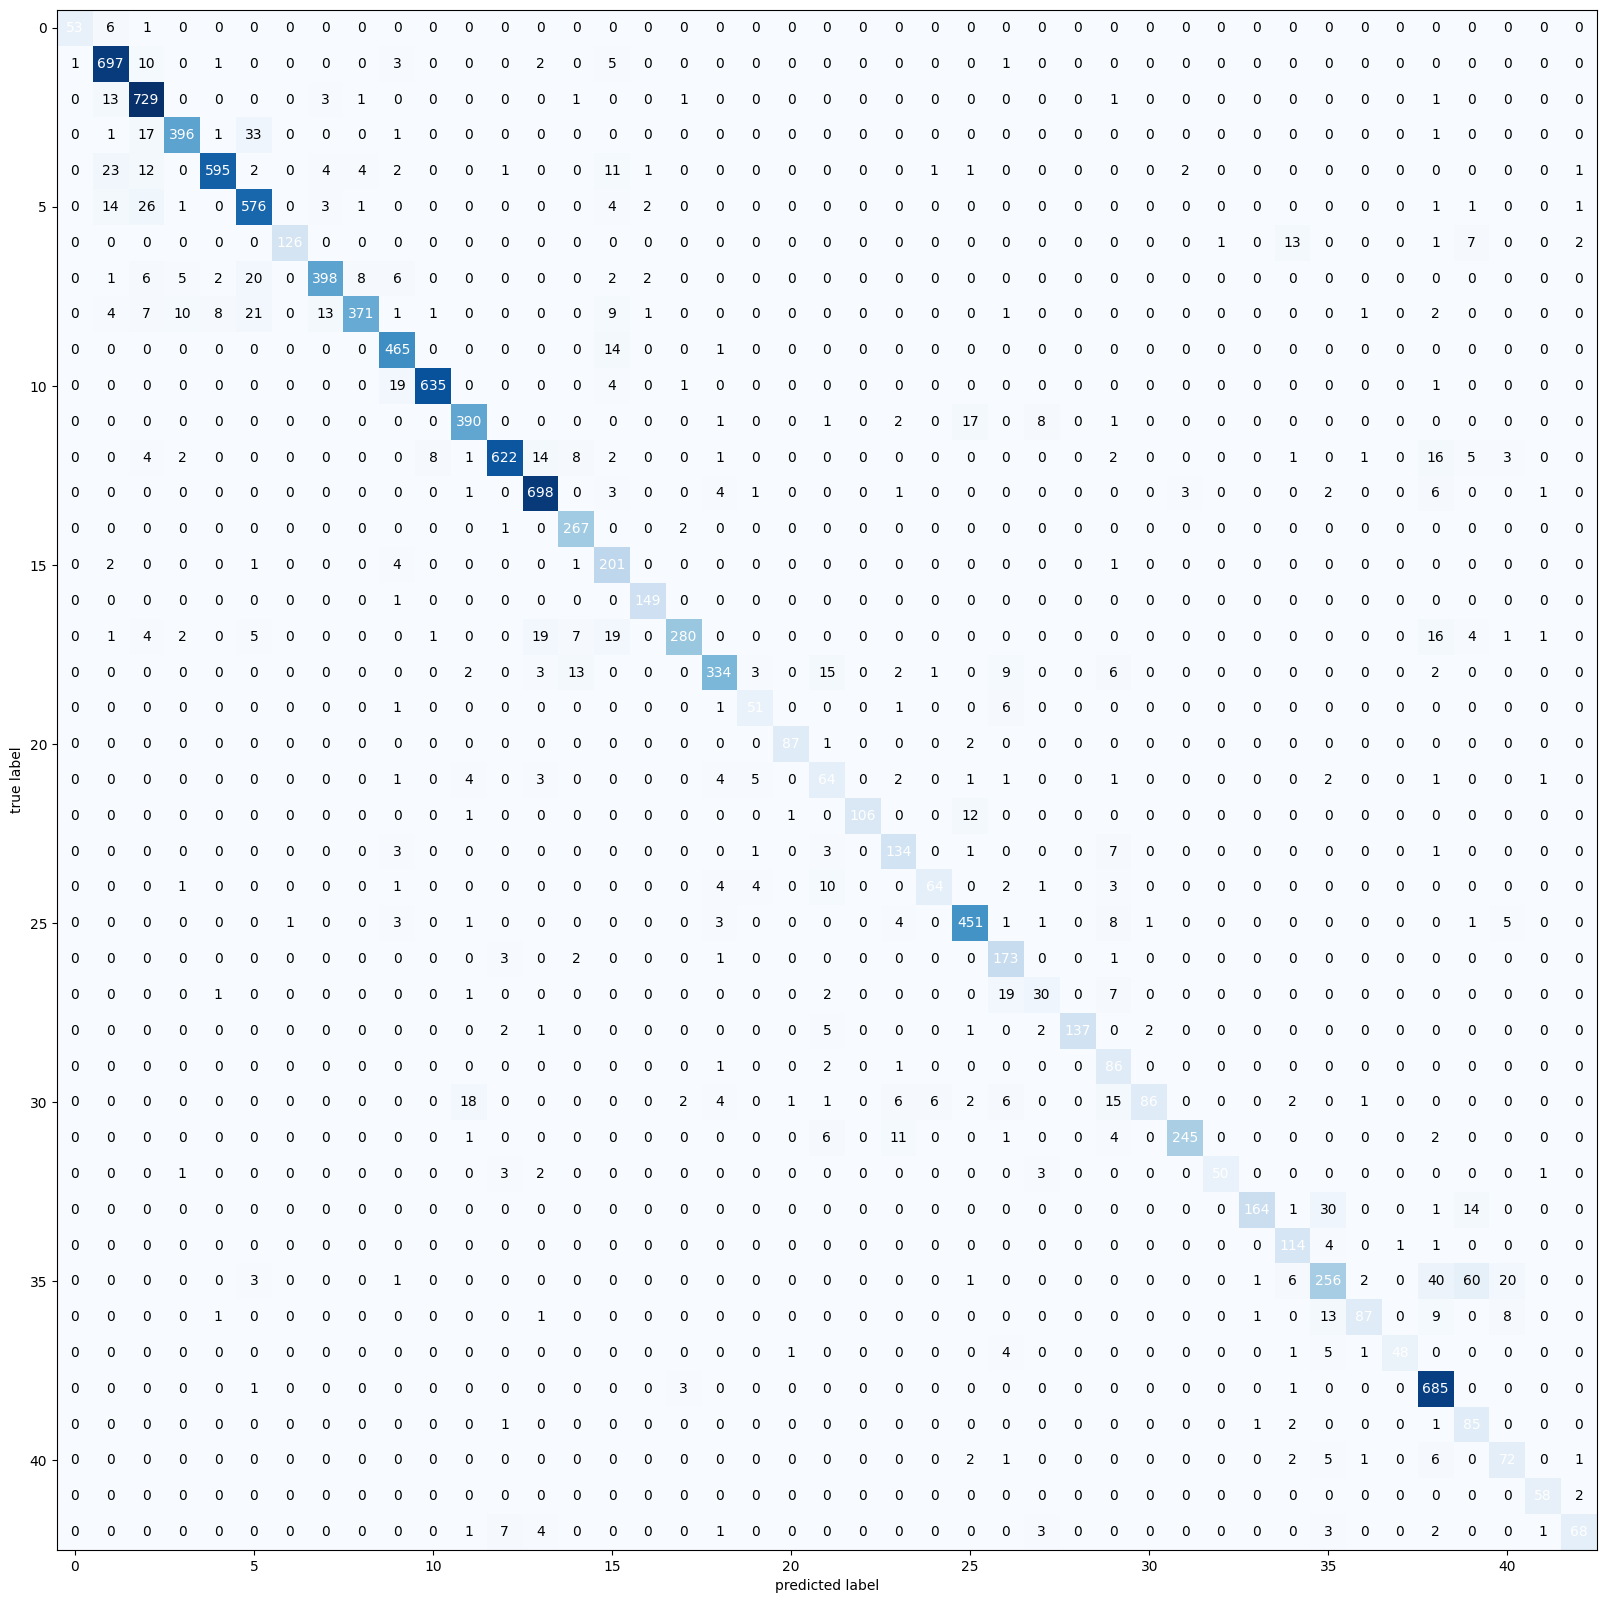

validation

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.95      0.96      0.95       240
           2       0.92      1.00      0.96       240
           3       0.97      0.95      0.96       150
           4       0.97      0.99      0.98       210
           5       0.95      0.99      0.97       210
           6       1.00      0.97      0.98        60
           7       0.96      0.95      0.96       150
           8       0.99      0.88      0.93       150
           9       0.95      0.99      0.97       150
          10       1.00      1.00      1.00       210
          11       0.91      1.00      0.95       150
          12       0.97      1.00      0.99       210
          13       0.98      0.99      0.99       240
          14       0.82      0.96      0.88        90
          15       0.82      0.99      0.89        90
          16       0.92      0.37      0.52  

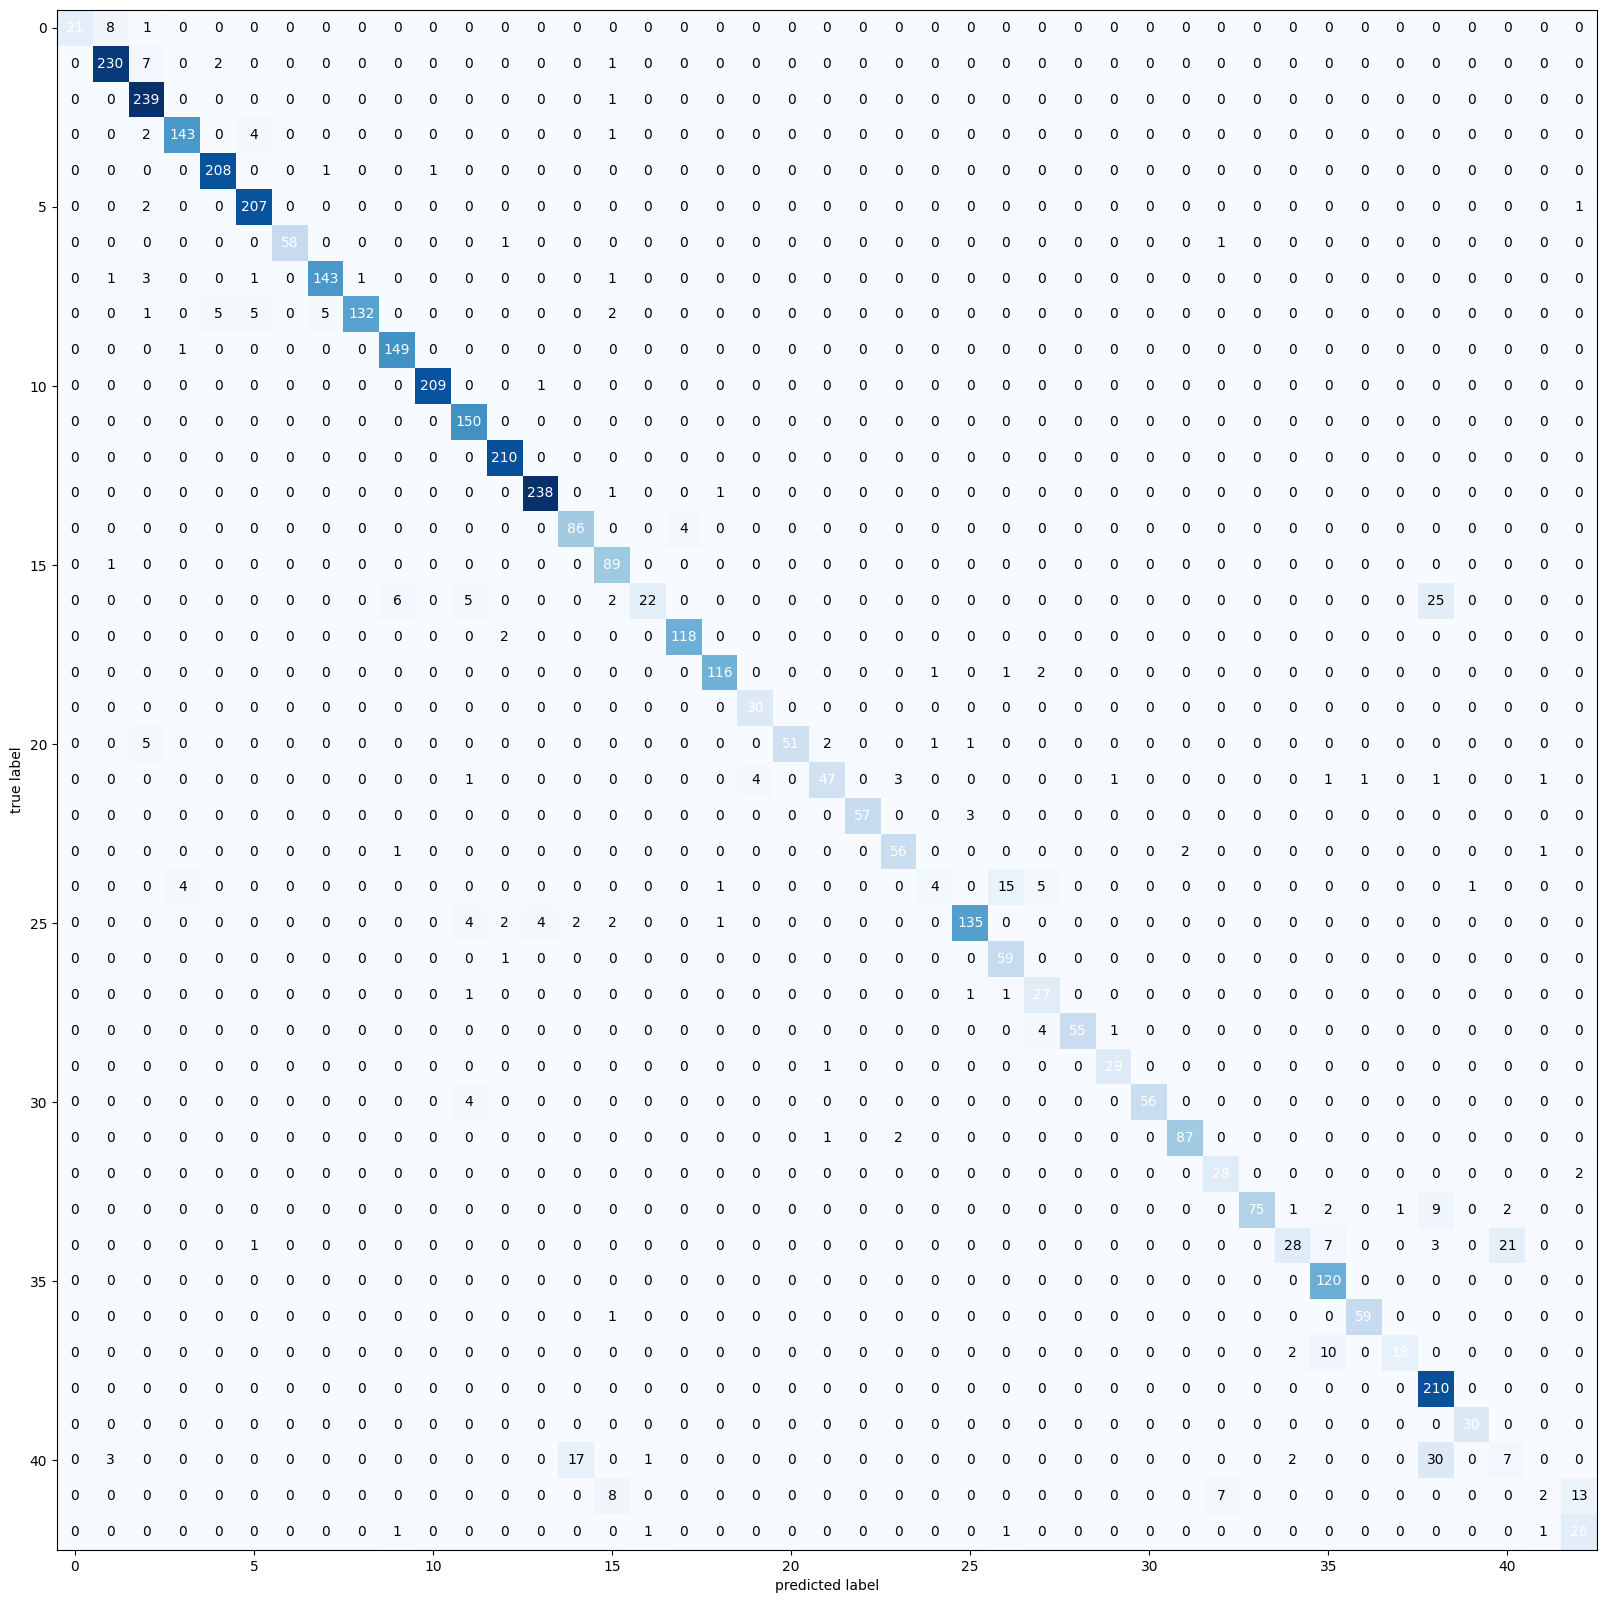

In [ ]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

# Visualize the output of multiple random images on different layers of your network and try to explain them. (Extra point)

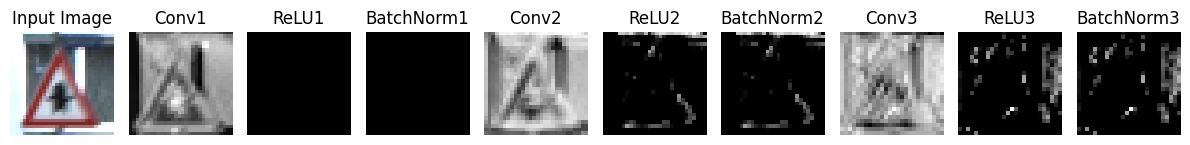

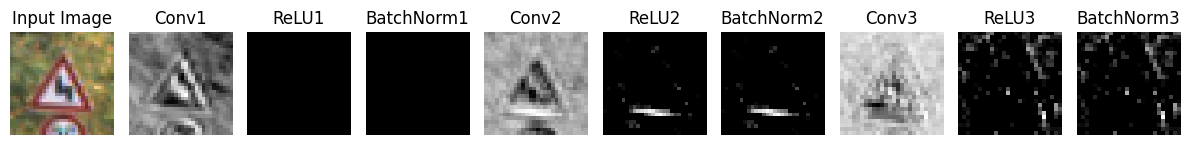

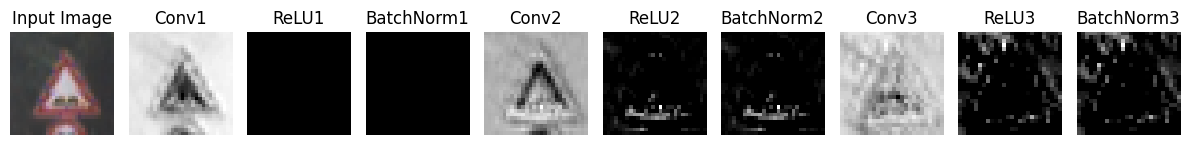

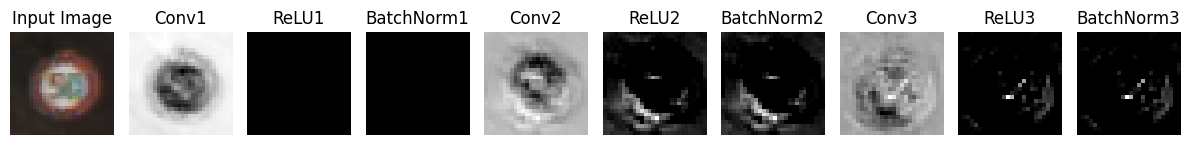

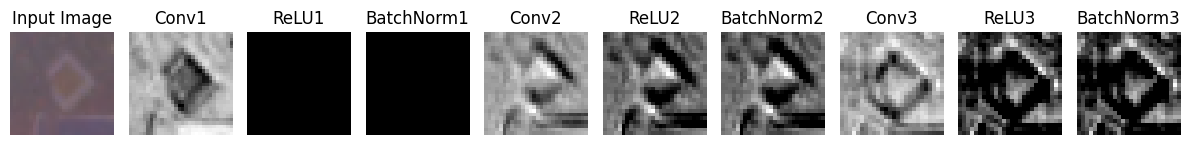

In [ ]:
def visualize_outputs(model, dataLoader, num_images=5):
    model.eval()

    # Select random images from the data loader
    images = []
    for step, batch in enumerate(dataLoader):
        x = batch["x"]
        images.append(x)
        if step == num_images - 1:
            break

    # Pass the images through the model and store intermediate outputs
    outputs = []
    with torch.no_grad():
        for image in images:
            intermediate_outputs = []
            x = image
            for layer in model.conv:
                x = layer(x)
                intermediate_outputs.append(x)
            
            outputs.append(intermediate_outputs)

    # Visualize the intermediate outputs
    layer_names = ['Conv1', 'ReLU1', 'BatchNorm1', 'Conv2', 'ReLU2', 'BatchNorm2', 'Conv3', 'ReLU3', 'BatchNorm3']
    for i, image in enumerate(images):
        plt.figure(figsize=(12, 8))
        plt.subplot(1, len(outputs[i]) + 1, 1)
        plt.title('Input Image')
        plt.imshow(image[0].permute(1, 2, 0))
        plt.axis('off')

        for j, output in enumerate(outputs[i]):
            plt.subplot(1, len(outputs[i]) + 1, j+2)
            plt.title(layer_names[j])
            plt.imshow(output[0, 0], cmap='gray')  # Adjust indexing based on the output tensor shape
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the visualize_outputs function with your model and data loader
visualize_outputs(model, dataLoader_test, num_images=5)


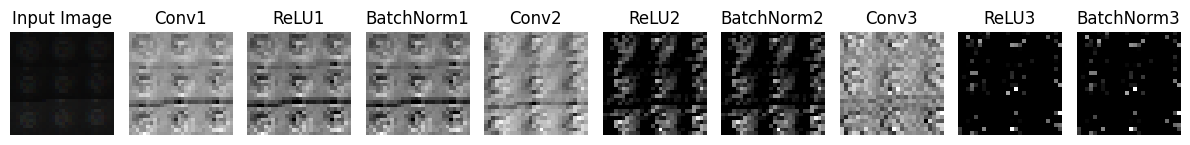

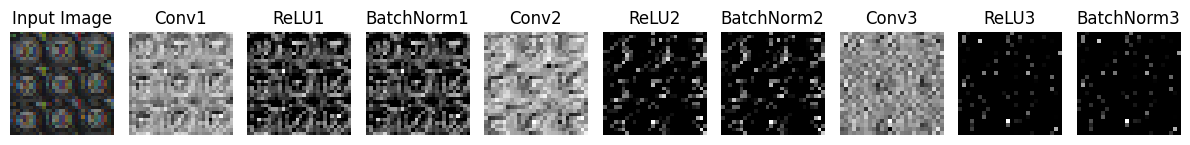

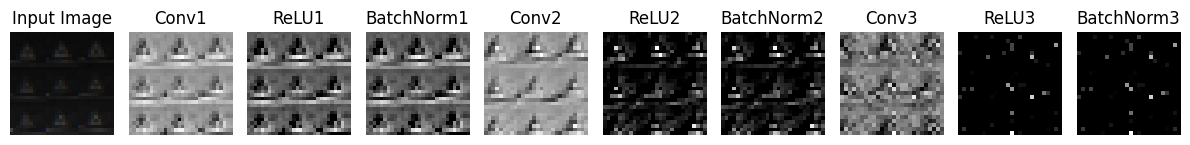

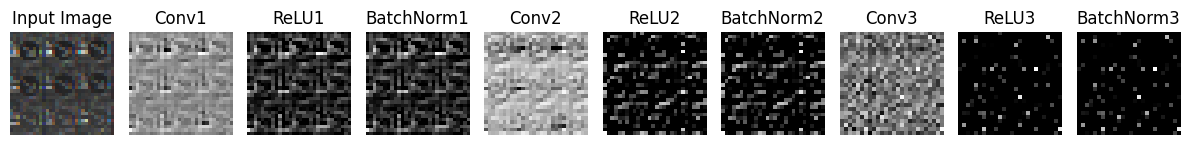

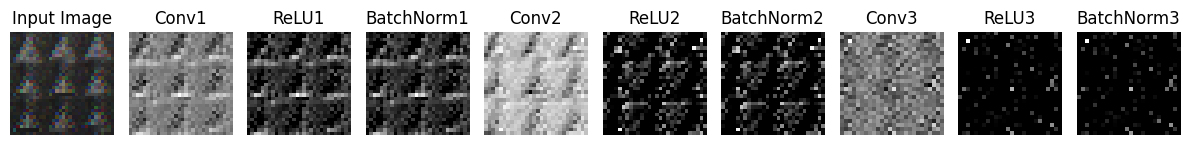

In [ ]:
import matplotlib.pyplot as plt

def visualize_outputs(model, dataLoader, num_images=5):
    model.eval()

    # Select random images from the data loader
    images = []
    for step, batch in enumerate(dataLoader):
        x = batch["x"]
        images.append(x)
        if step == num_images - 1:
            break

    # Pass the images through the model and store intermediate outputs
    outputs = []
    with torch.no_grad():
        for image in images:
            intermediate_outputs = []
            x = image
            for layer in model.conv:
                x = layer(x)
                intermediate_outputs.append(x)
            
            outputs.append(intermediate_outputs)

    # Visualize the intermediate outputs
    layer_names = ['Conv1', 'ReLU1', 'BatchNorm1', 'Conv2', 'ReLU2', 'BatchNorm2', 'Conv3', 'ReLU3', 'BatchNorm3']
    for i, image in enumerate(images):
        plt.figure(figsize=(12, 8))
        plt.subplot(1, len(outputs[i]) + 1, 1)
        plt.title('Input Image')
        plt.imshow(image[0].permute(1, 2, 0))
        plt.axis('off')

        for j, output in enumerate(outputs[i]):
            plt.subplot(1, len(outputs[i]) + 1, j+2)
            plt.title(layer_names[j])
            plt.imshow(output[0, 0], cmap='gray')  # Adjust indexing based on the output tensor shape
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Call the visualize_outputs function with your model and data loader
visualize_outputs(model, dataLoader_test, num_images=5)


# Visualize different images in the train set and compare them in terms of illumination, aspect ratio, or other aspects. Try to use appropriate transformation to pre-process the images and boost your model’s performance. For, example in terms of illumination, if images differ considerably, you can use Histogram Equalization to solve the issue. (Extra point)

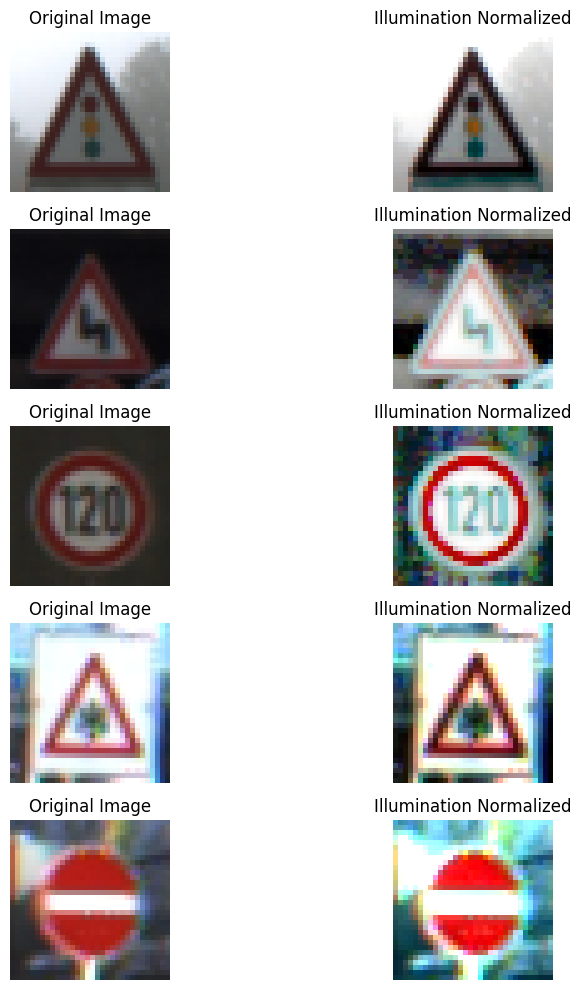

In [ ]:
# Define the transformation for illumination normalization using histogram equalization
illumination_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.functional.equalize,
    transforms.ToTensor()
])

# Function to visualize images
def visualize_images(dataLoader, num_images=5):
    data_iter = iter(dataLoader)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))
    for i in range(num_images):
        sample = next(data_iter)
        image = sample['x'][0]  # Assuming batch size of 1
        transformed_image = illumination_transform(image)
        
        axes[i, 0].imshow(image.permute(1, 2, 0))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(transformed_image.permute(1, 2, 0))
        axes[i, 1].set_title('Illumination Normalized')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize images in the train set
visualize_images(dataLoader_train)

# Try to make a custom CNN model to perform best on the data. Use various techniques to boost your performance.

In [ ]:
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            torch.nn.Sigmoid(),
            torch.nn.BatchNorm2d(128),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 512),
            torch.nn.Sigmoid(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x

model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Sigmoid()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): Sigmoid()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): Sigmoid()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): Sigmoid()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): Sigmoid()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Seque

In [ ]:
n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,  train_batch_loss / len(dataLoader_train), test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_RGB')

started!
epoch 1/3 finished with train loss: 2.6193986219518326 and test loss: 1.7084433937072754
epoch 2/3 finished with train loss: 0.6872670702526674 and test loss: 0.2776972132921219
epoch 3/3 finished with train loss: 0.06162752042634084 and test loss: 0.13888427153229713


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.97      0.97      0.97       450
           4       1.00      0.98      0.99       660
           5       0.94      0.99      0.96       630
           6       0.99      0.96      0.98       150
           7       1.00      0.98      0.99       450
           8       0.96      0.94      0.95       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.98       660
          11       0.98      0.96      0.97       420
          12       0.97      0.97      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      0.99      0.99       210
          16       1.00      1.00      1.00       1

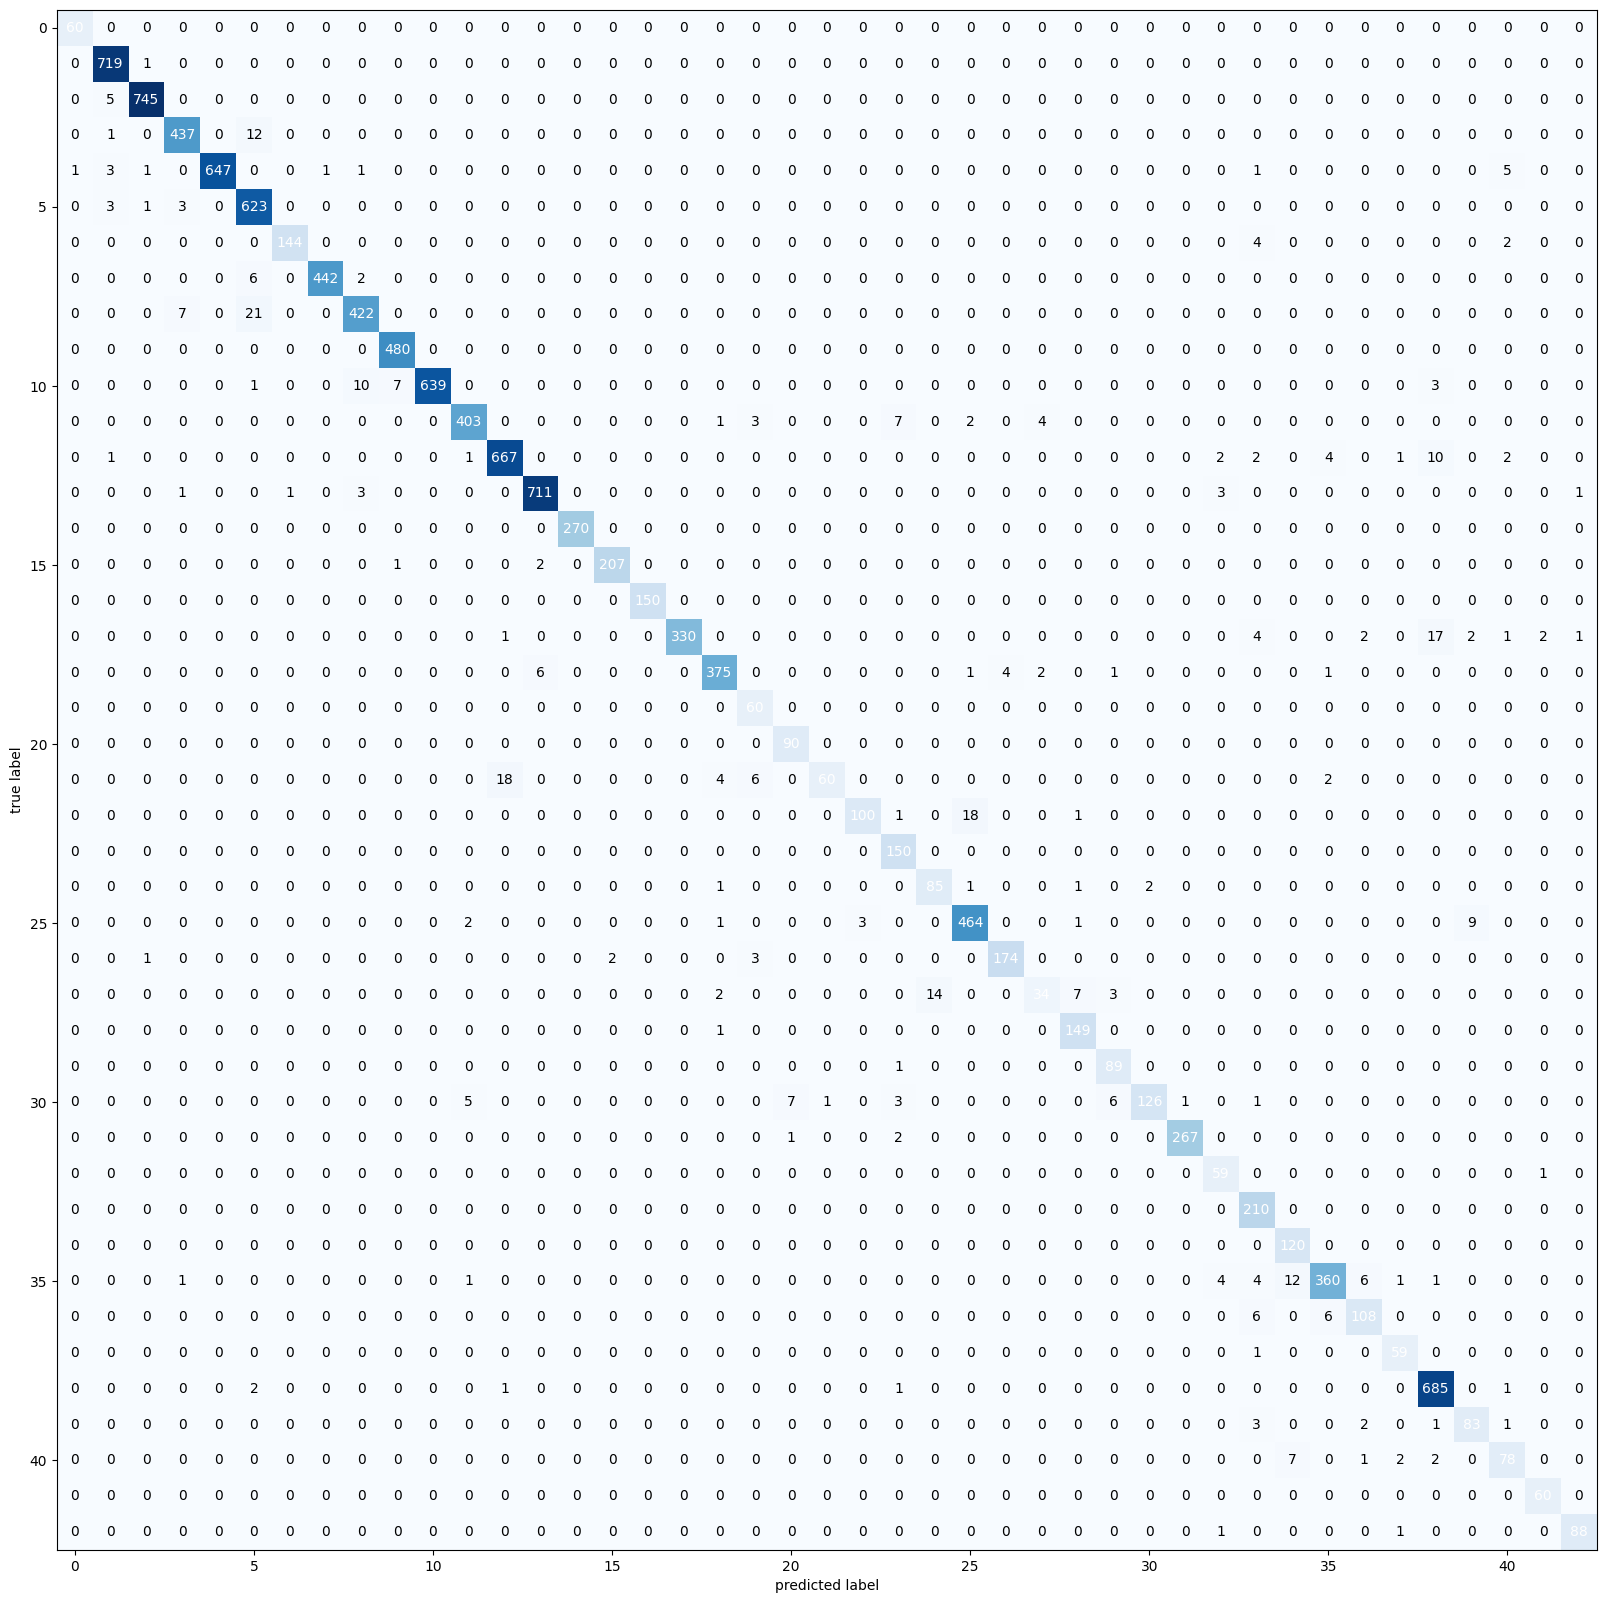

validation

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.96      1.00      0.98       240
           2       1.00      1.00      1.00       240
           3       0.99      1.00      1.00       150
           4       0.99      1.00      0.99       210
           5       0.99      1.00      0.99       210
           6       0.94      1.00      0.97        60
           7       1.00      1.00      1.00       150
           8       1.00      0.97      0.98       150
           9       1.00      1.00      1.00       150
          10       1.00      1.00      1.00       210
          11       0.84      1.00      0.91       150
          12       0.99      1.00      0.99       210
          13       1.00      1.00      1.00       240
          14       0.99      0.98      0.98        90
          15       1.00      1.00      1.00        90
          16       1.00      0.50      0.67  

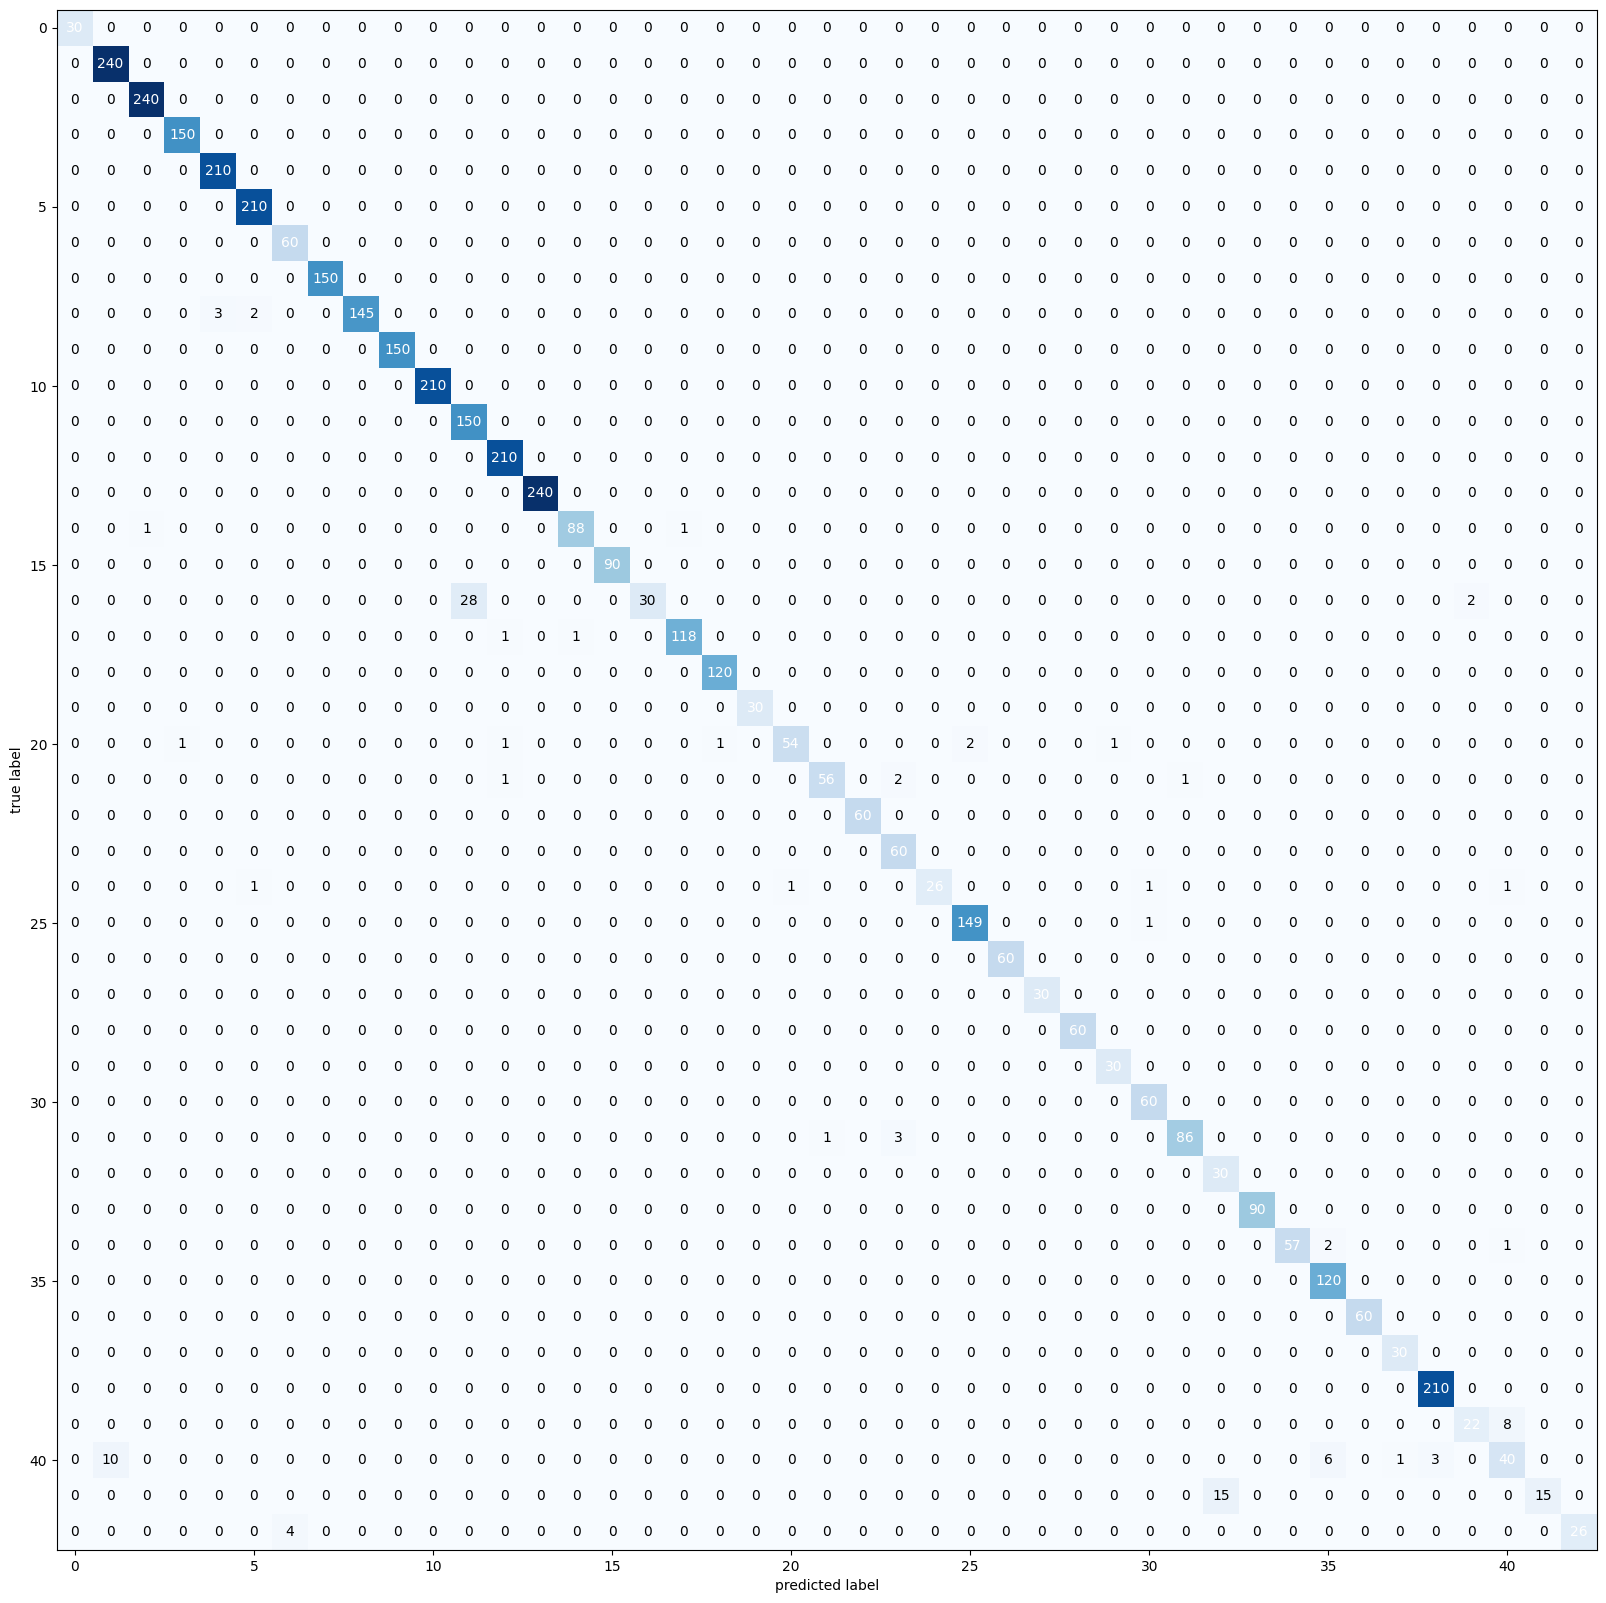

In [ ]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

**7Layer**

In [ ]:
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x

model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (16): ReLU()
    (17): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
n_epochs = 3
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,  train_batch_loss / len(dataLoader_train), test_batch_loss / len(dataLoader_test)))
    
torch.save(model.state_dict(), './model_RGB')

started!
epoch 1/3 finished with train loss: 0.8867581689401585 and test loss: 0.16839143007993698
epoch 2/3 finished with train loss: 0.024456899191992468 and test loss: 0.15456693574786187
epoch 3/3 finished with train loss: 0.011450704277034247 and test loss: 0.15508933797478675


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       1.00      0.96      0.98       450
           4       1.00      0.98      0.99       660
           5       0.92      1.00      0.96       630
           6       0.99      0.97      0.98       150
           7       0.99      1.00      1.00       450
           8       1.00      0.93      0.96       450
           9       0.99      0.99      0.99       480
          10       1.00      1.00      1.00       660
          11       0.90      0.99      0.94       420
          12       0.99      0.91      0.95       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.99      0.97      0.98       210
          16       0.99      1.00      0.99       1

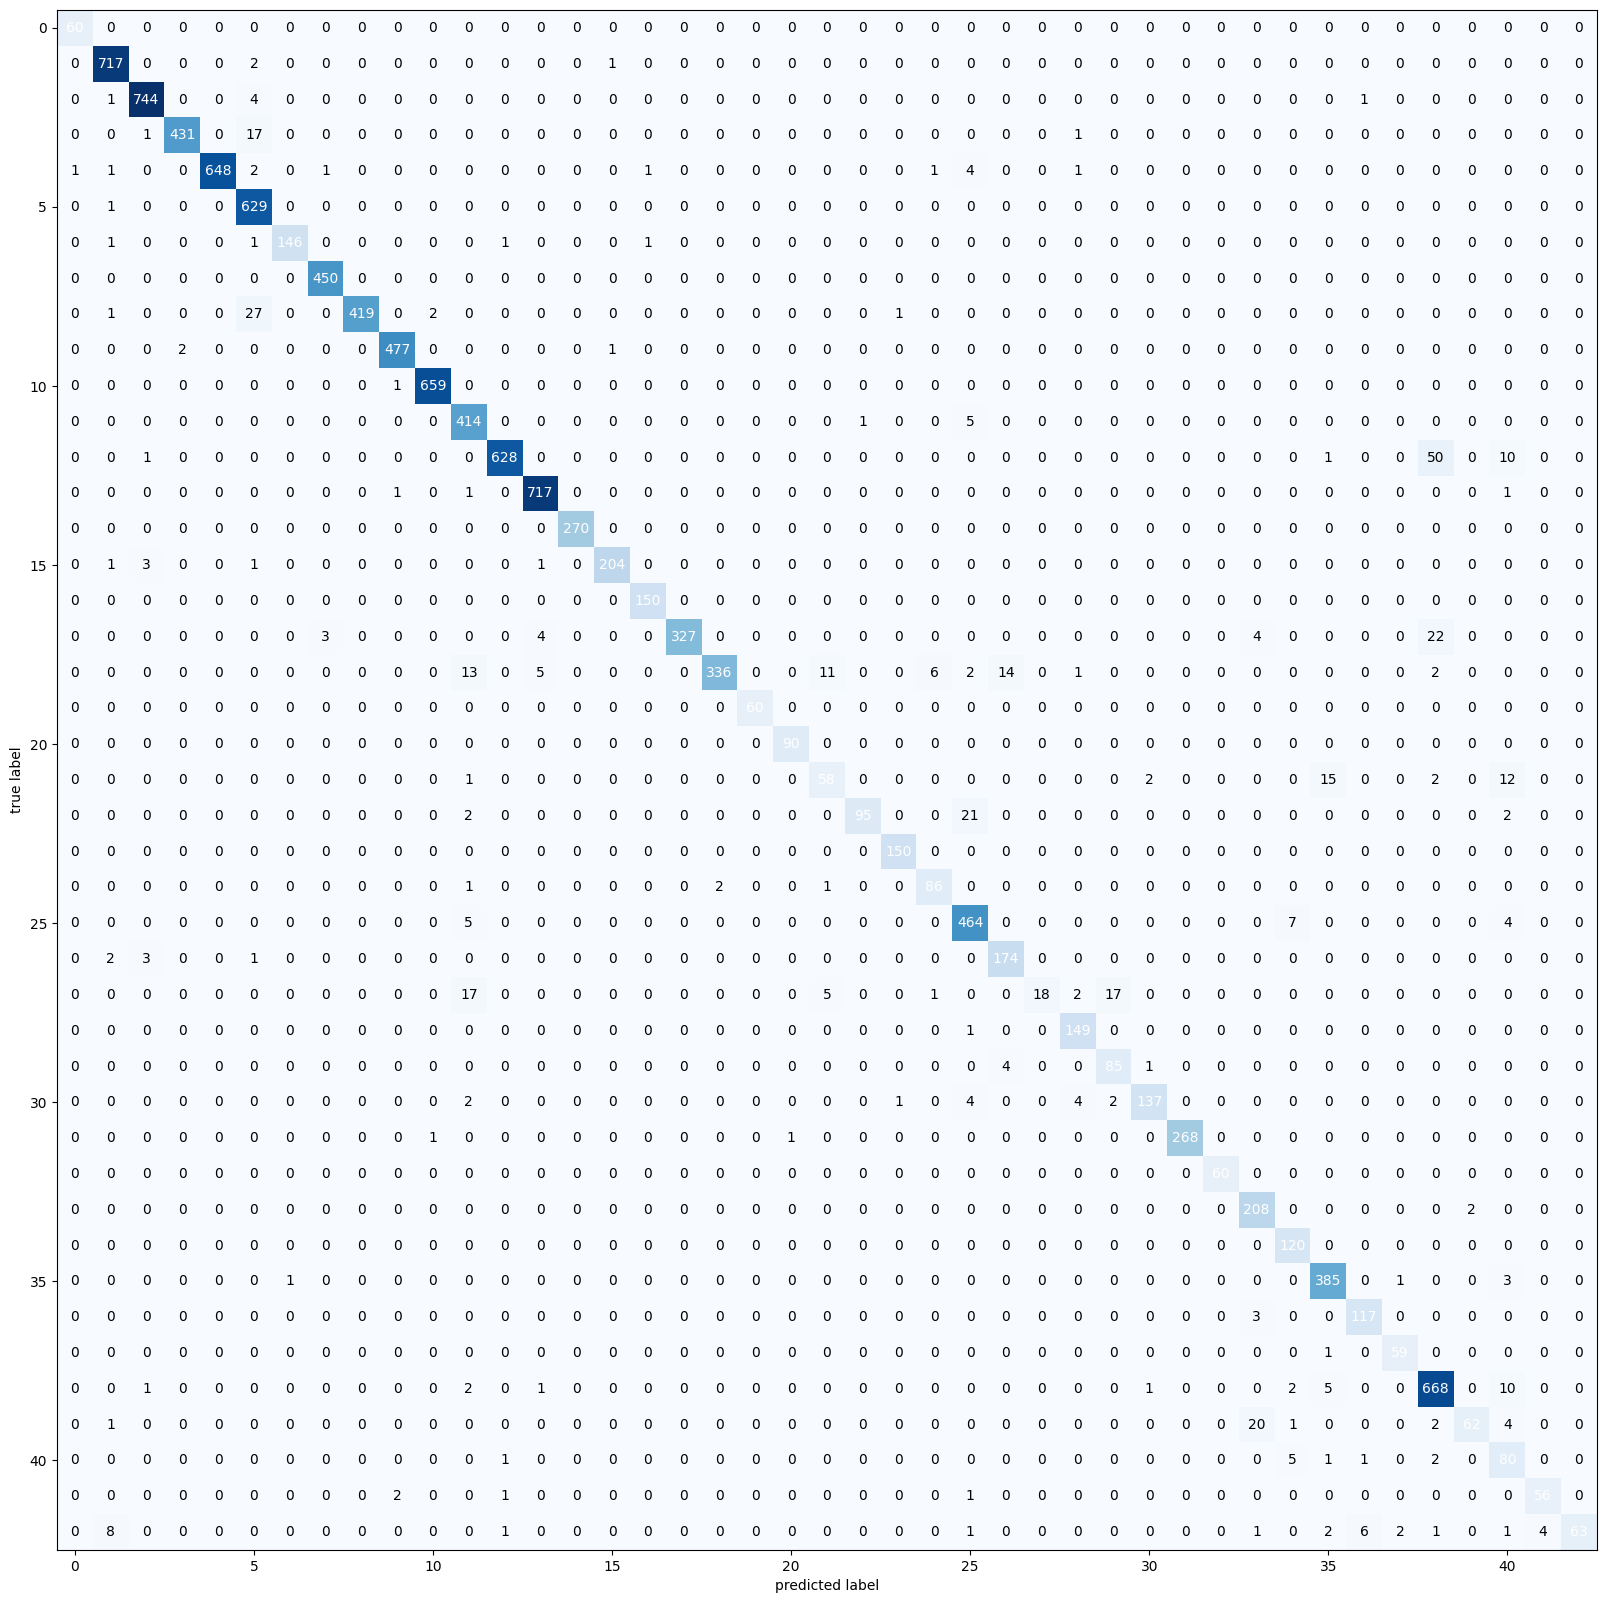

validation

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00       240
           2       1.00      0.99      0.99       240
           3       1.00      0.98      0.99       150
           4       1.00      0.99      0.99       210
           5       0.97      1.00      0.99       210
           6       1.00      0.98      0.99        60
           7       0.95      1.00      0.97       150
           8       1.00      0.94      0.97       150
           9       1.00      0.98      0.99       150
          10       1.00      1.00      1.00       210
          11       0.83      1.00      0.91       150
          12       0.96      1.00      0.98       210
          13       1.00      0.99      1.00       240
          14       1.00      1.00      1.00        90
          15       0.97      1.00      0.98        90
          16       0.97      0.50      0.66  

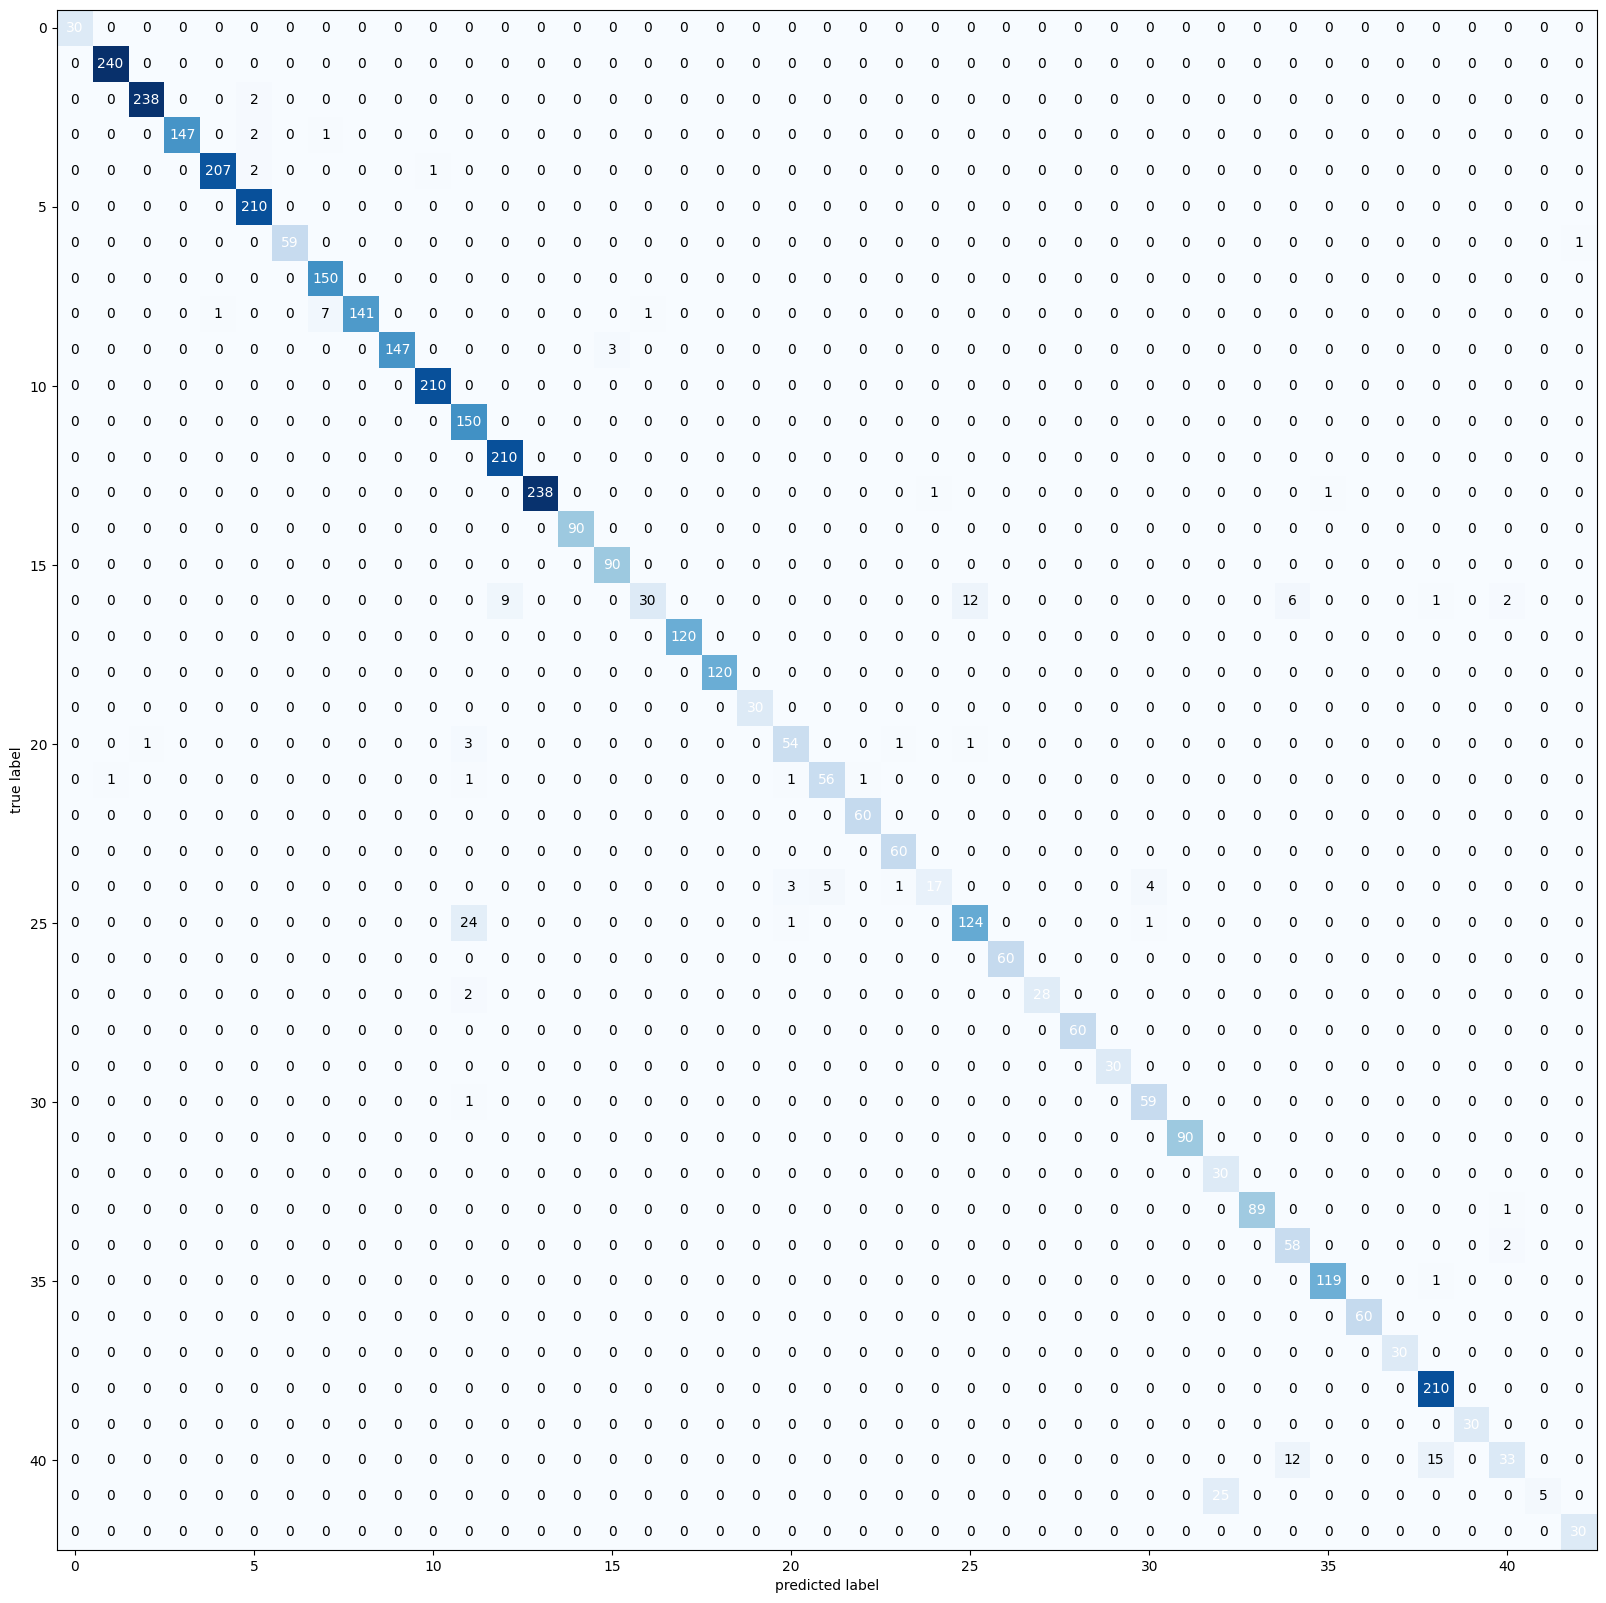

In [ ]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

# Try to solve the problem using Transfer Learning by utilizing various pre-trained models.


In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 30

IMG_SIZE = 32
N_CLASSES = 43

In [ ]:
def get_accuracy(model, dataLoader, device):
    
    correct_pred = 0 
    n = 0
    
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            _, outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            pred_labels = torch.max(outputs, 1)[1]
            
            n += true_labels.size(0)
            correct_pred += (pred_labels == true_labels).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    plt.style.use('default')

In [ ]:
def train(dataLoader_train, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs, _ = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
    epoch_loss = train_batch_loss / len(dataLoader_train)
    return model, optimizer, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [ ]:
def validate(dataLoader_validation, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    validation_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_validation):
        x = batch["x"]
        y = batch["y"]

        outputs, _ = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        validation_batch_loss += loss.item()

    epoch_loss = validation_batch_loss / len(dataLoader_validation)
        
    return model, epoch_loss

**LeNet5**

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, start_channels=3):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=start_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ELU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) #transforma a matrix x em vetor.
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

Epoch: 0	Train loss: 2.7427	Valid loss: 1.7937	Train accuracy: 50.35	Valid accuracy: 47.41
Epoch: 1	Train loss: 1.1695	Valid loss: 0.9984	Train accuracy: 73.22	Valid accuracy: 70.18
Epoch: 2	Train loss: 0.6976	Valid loss: 0.7741	Train accuracy: 84.88	Valid accuracy: 79.37
Epoch: 3	Train loss: 0.4770	Valid loss: 0.7637	Train accuracy: 87.63	Valid accuracy: 78.14
Epoch: 4	Train loss: 0.3666	Valid loss: 0.6272	Train accuracy: 91.95	Valid accuracy: 83.02
Epoch: 5	Train loss: 0.2713	Valid loss: 0.5783	Train accuracy: 93.70	Valid accuracy: 85.28
Epoch: 6	Train loss: 0.2182	Valid loss: 0.5599	Train accuracy: 95.76	Valid accuracy: 85.35
Epoch: 7	Train loss: 0.1738	Valid loss: 0.5163	Train accuracy: 96.67	Valid accuracy: 86.96
Epoch: 8	Train loss: 0.1373	Valid loss: 0.5083	Train accuracy: 97.15	Valid accuracy: 87.96
Epoch: 9	Train loss: 0.1182	Valid loss: 0.5570	Train accuracy: 97.56	Valid accuracy: 87.55
Epoch: 10	Train loss: 0.0965	Valid loss: 0.4608	Train accuracy: 98.11	Valid accuracy: 88.2

<ipython-input-22-5f9876c8e368>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


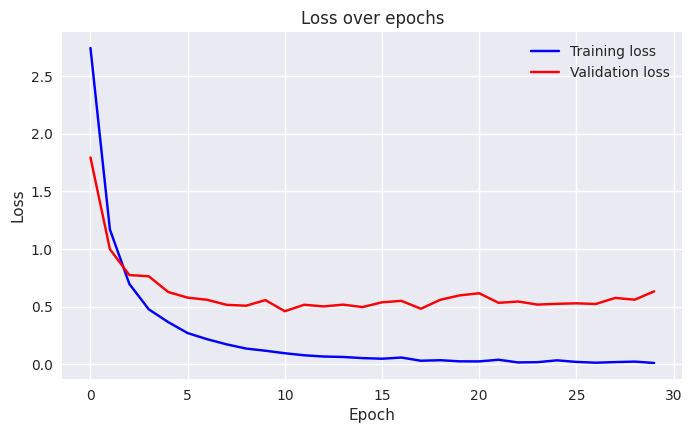

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, dataLoader_train, dataLoader_validation, N_EPOCHS, device)

In [ ]:
def test_accuracy(data_loader, model, device):
    """
    Function to compute the test accuracy of the model
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            x = batch["x"].to(device)  # Move input tensor to the GPU
            y = batch["y"].to(device)  # Move target tensor to the GPU
            outputs, _ = model(x)
            _, predicted = torch.max(outputs.data.cpu(), 1)  # Move predictions to CPU for comparison
            total += y.size(0)
            correct += (predicted == torch.max(y.cpu(), 1)[1]).sum().item()  # Move target to CPU for comparison

    accuracy = correct / total
    return accuracy

test_accuracy(dataLoader_test, model, device)

0.8914489311163896

**mobilenet_v2**

In [ ]:
#class MobileNet(nn.Module):
#    def __init__(self, n_classes, start_channels=3):
#        super(MobileNet, self).__init__()
#
#        self.feature_extractor = mobilenet_v2()
#        num_features = self.feature_extractor.classifier[1].in_features
#
        # Replace the classifier
#        self.feature_extractor.classifier[1] = nn.Linear(num_features, n_classes)
#
#    def forward(self, x):
#        x = self.feature_extractor(x)
#        logits = x
#        probs = F.softmax(logits, dim=1)
#        return logits, probs


In [ ]:
#torch.manual_seed(RANDOM_SEED)

#model = MobileNet(N_CLASSES).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()

#model, optimizer, _ = training_loop(model, criterion, optimizer, dataLoader_train, dataLoader_validation, N_EPOCHS, device)

In [ ]:
#test_accuracy(dataLoader_test, model, device)

**EfficientNetModel**

In [ ]:
#class EfficientNetModel(nn.Module):
#    def __init__(self, n_classes, start_channels=3):
#        super(EfficientNetModel, self).__init__()
#
#        self.feature_extractor = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1000)
#        self.classifier = nn.Sequential(
#            nn.Linear(1000, 84),
#            nn.ELU(),
#            nn.Linear(84, n_classes),
#        )
#
#    def forward(self, x):
#        features = self.feature_extractor(x)
#        x = torch.flatten(features, 1)
#        logits = self.classifier(x)
#        probs = F.softmax(logits, dim=1)
#        return logits, probs

In [ ]:
#torch.manual_seed(RANDOM_SEED)

#model = EfficientNetModel(N_CLASSES).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()

#model, optimizer, _ = training_loop(model, criterion, optimizer, dataLoader_train, dataLoader_validation, N_EPOCHS, device)

In [ ]:
#test_accuracy(dataLoader_test, model, device)

# Check whether using grayscale images affects the performance of the model or not.


In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.transform(self.x[idx].astype(np.uint8).reshape((32, 32, 3)))

        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)

        return {'x': x, 'y': label}

BATCH_SIZE = 256

train_dataset = MyDataset(train_features, train_labels, 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset(test_features, test_labels, 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = MyDataset(valid_features, valid_labels, 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Model(torch.nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )
        
        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(64, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x) 
        x = self.fc(x)
        return x
    
model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=43, bias=True)
  )
)


In [ ]:
print('started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()
    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch+1, n_epochs,
                                                                              train_batch_loss / len(dataLoader_train),
                                                                              test_batch_loss / len(dataLoader_test)))

started!
epoch 1/3 finished with train loss: 2.000392737195772 and test loss: 0.9028596031665802
epoch 2/3 finished with train loss: 0.27978418778408976 and test loss: 0.4191723197698593
epoch 3/3 finished with train loss: 0.1193039973047288 and test loss: 0.3887844601273537


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        60
           1       0.90      0.99      0.94       720
           2       0.98      0.96      0.97       750
           3       0.96      0.88      0.92       450
           4       0.98      0.91      0.94       660
           5       0.86      0.95      0.91       630
           6       0.95      0.78      0.86       150
           7       0.98      0.91      0.95       450
           8       0.94      0.91      0.92       450
           9       0.95      0.95      0.95       480
          10       0.96      0.98      0.97       660
          11       0.93      0.97      0.95       420
          12       0.85      0.96      0.90       690
          13       0.94      0.99      0.97       720
          14       0.91      0.93      0.92       270
          15       0.85      0.92      0.88       210
          16       0.85      1.00      0.92       1

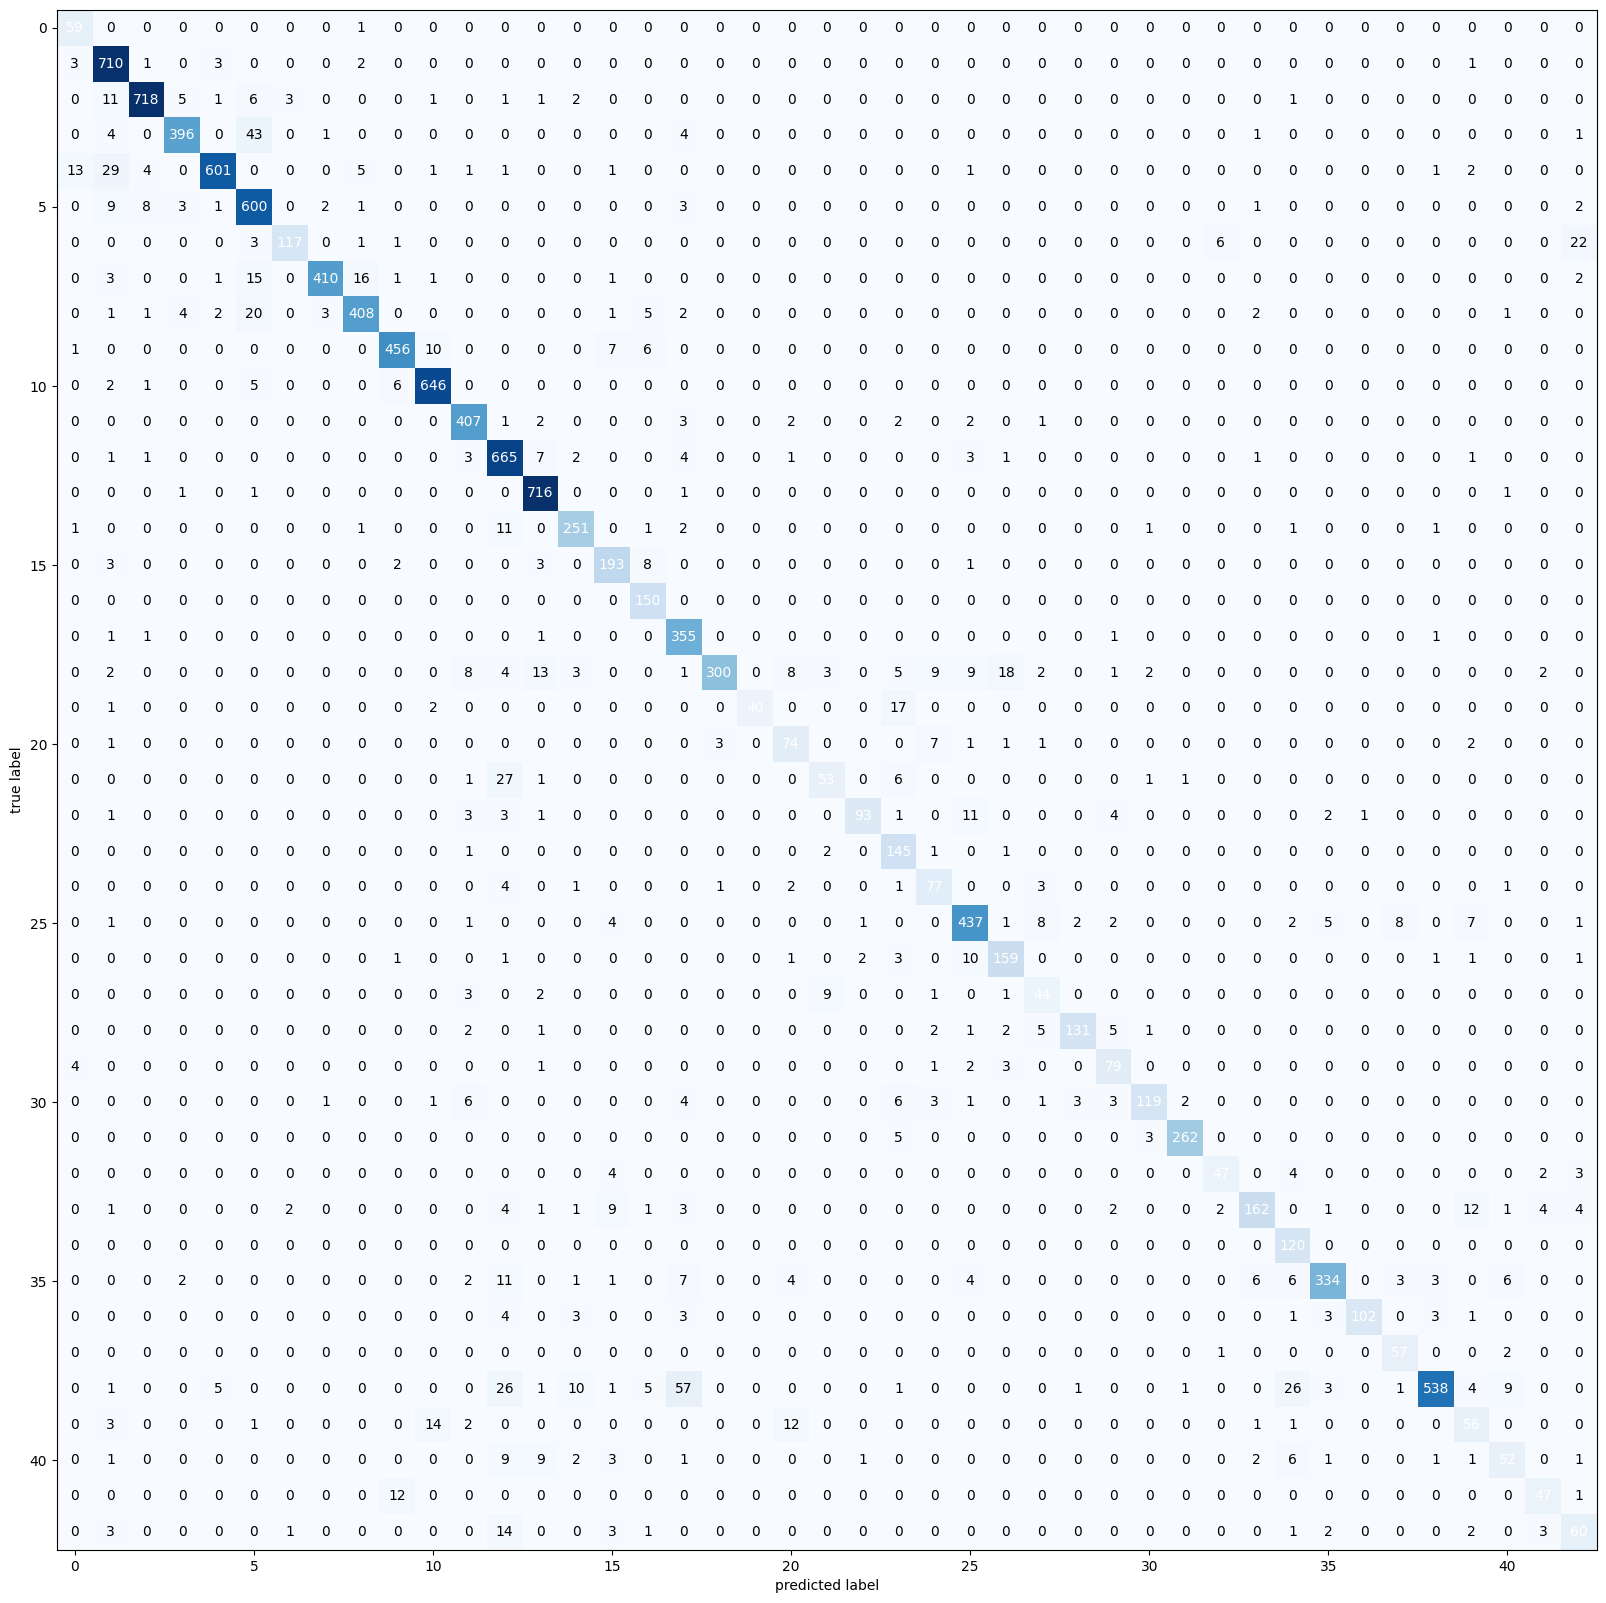

validation

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       0.91      0.99      0.95       240
           2       0.97      0.99      0.98       240
           3       0.98      0.96      0.97       150
           4       0.99      0.98      0.98       210
           5       0.94      0.99      0.96       210
           6       1.00      0.98      0.99        60
           7       0.99      0.97      0.98       150
           8       0.99      0.97      0.98       150
           9       0.97      0.95      0.96       150
          10       0.98      0.98      0.98       210
          11       0.96      0.99      0.98       150
          12       0.94      0.98      0.96       210
          13       0.96      1.00      0.98       240
          14       0.99      0.94      0.97        90
          15       0.92      0.97      0.94        90
          16       0.95      0.63      0.76  

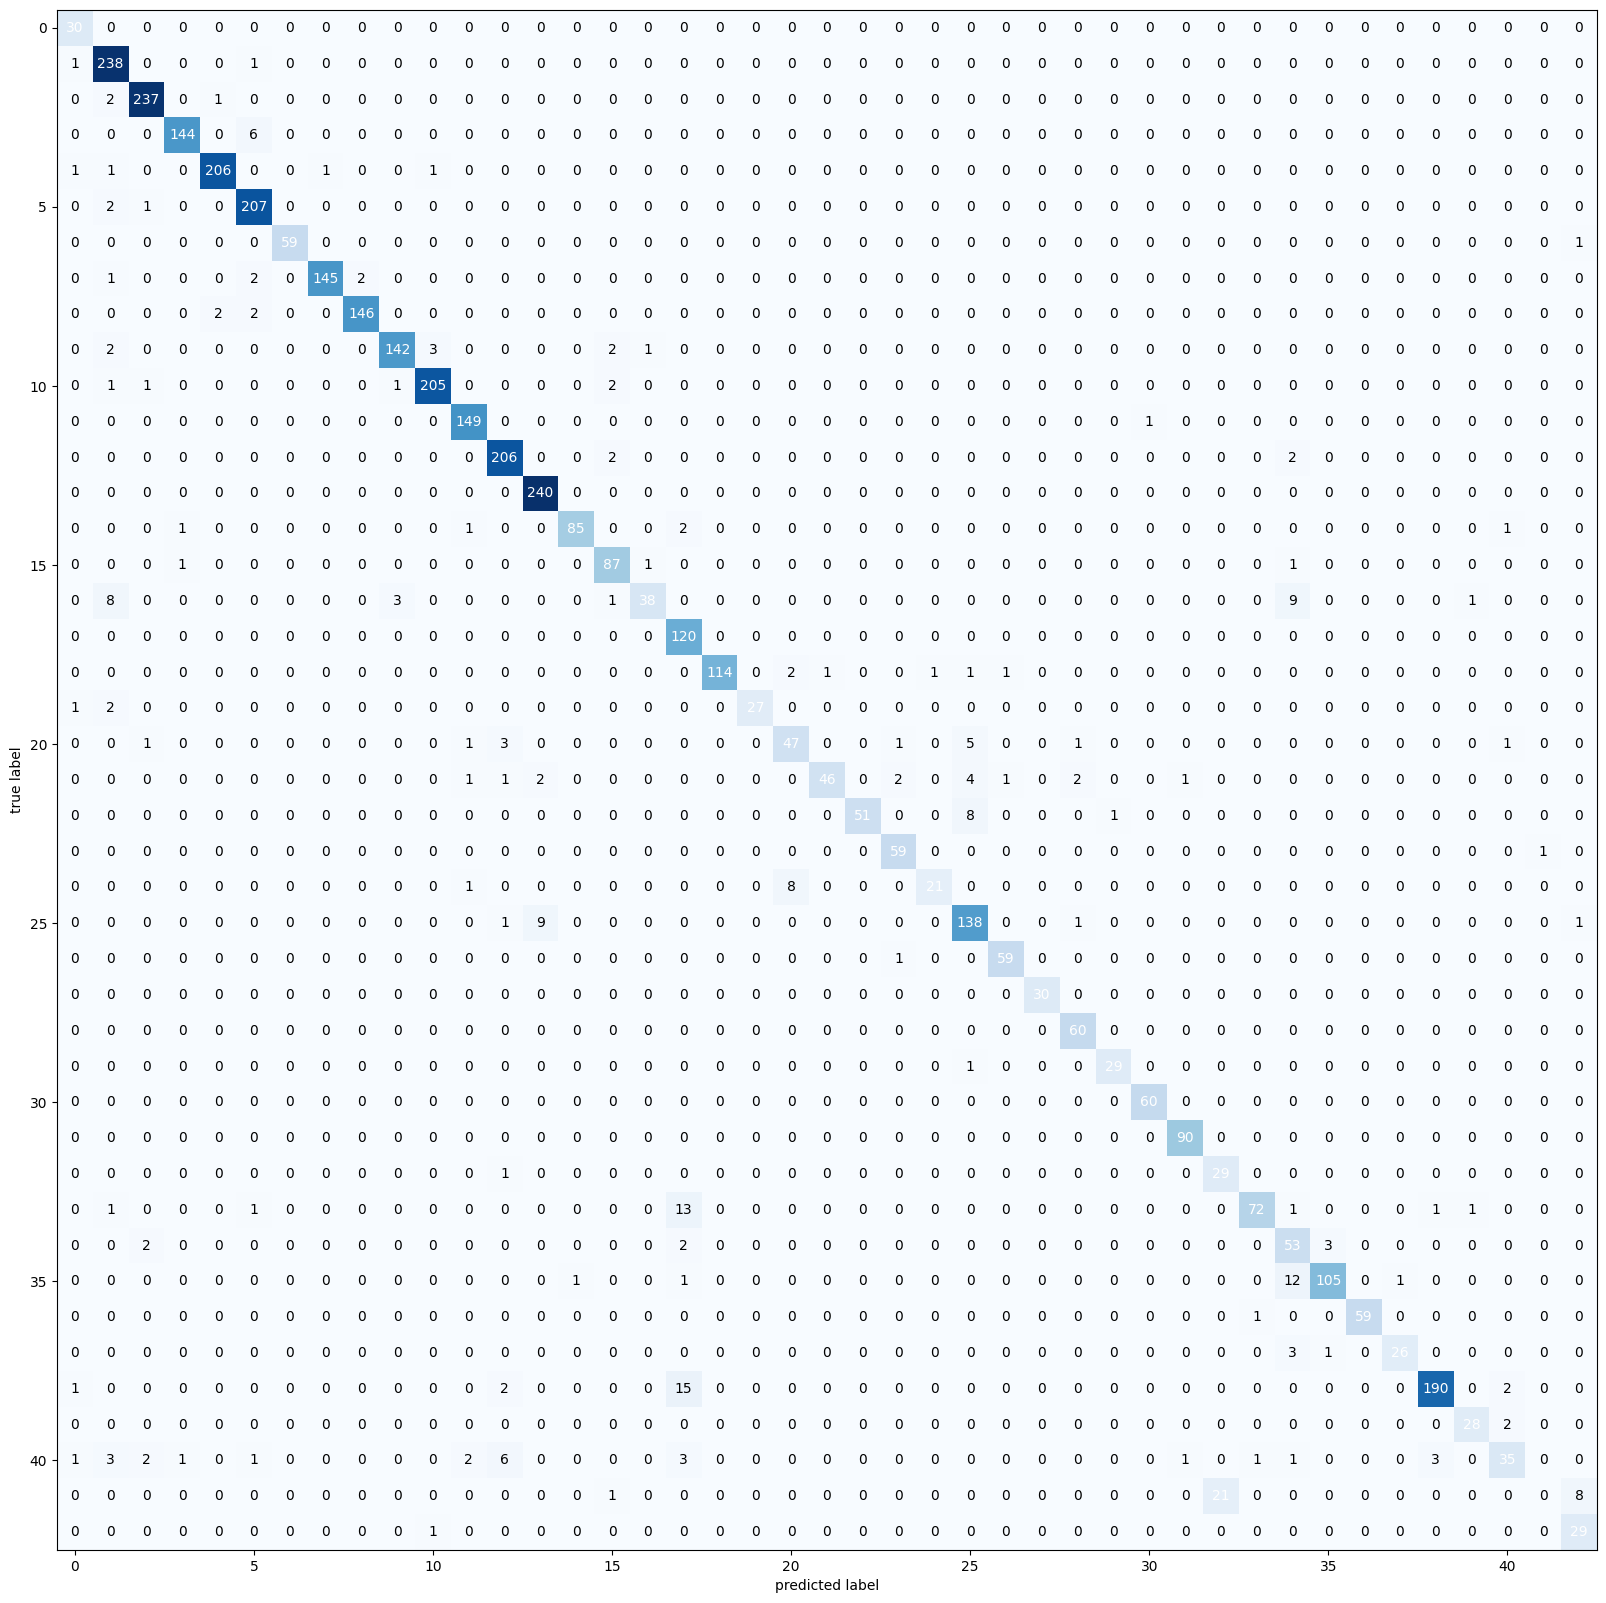

In [ ]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)

# Check whether the data is balanced or not. If not try to solve the problem and achieve better performance. (Hint: you can try up-sampling and down-sampling approaches to tackle this problem. For an up-sampling approach you can consider augmenting or synthesizing images)

(array([ 180., 1980., 2010., 1260., 1770., 1650.,  360., 1290., 1260.,
        1320., 1800., 1170., 1890., 1920.,  690.,  540.,  360.,  990.,
        1080.,  180.,  300.,  270.,  330.,  450.,  240., 1350.,  540.,
         210.,  480.,  240.,  390.,  690.,  210.,  599.,  360., 1080.,
         330.,  180., 1860.,  270.,  300.,  210.,  210.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <BarContai

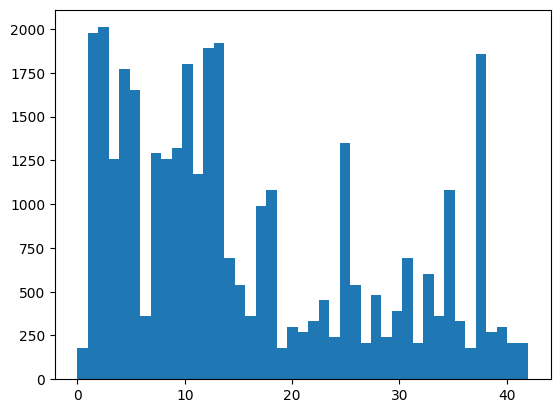

In [ ]:
plt.hist(train_labels, bins = 43)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, num_classes):
        self.x = x
        self.y = y
        self.n_class = num_classes
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        x = self.transform(x)

        label_idx = self.y[idx]
        label = np.zeros(self.n_class)
        label[label_idx] = 1
        label = torch.tensor(label)

        return {'x': x, 'y': label}

train_dataset = MyDataset(train_features, train_labels, 43)
dataLoader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset(test_features, test_labels, 43)
dataLoader_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = MyDataset(valid_features, valid_labels, 43)
dataLoader_validation = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
        )

        self.upsample = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )

        self.flatten = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d(1), torch.nn.Flatten())

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(32, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = Model(43)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Model(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flatten): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_featu

In [ ]:
n_epochs = 3
# Training loop
print('Started!')
for epoch in range(n_epochs):
    train_batch_loss = 0
    model.train()

    for step, batch in enumerate(dataLoader_train):
        x = batch["x"]
        y = batch["y"]

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, torch.max(y, 1)[1])
        loss.backward()
        optimizer.step()
        train_batch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()

    test_batch_loss = 0
    model.eval()

    with torch.no_grad():
        for step, batch in enumerate(dataLoader_test):
            x = batch["x"]
            y = batch["y"]
            outputs = model(x)
            loss = criterion(outputs, torch.max(y, 1)[1])
            test_batch_loss += loss.item()

    print('Epoch {}/{} finished with train loss: {} and test loss: {}'.format(epoch + 1, n_epochs, train_batch_loss / len(dataLoader_train), test_batch_loss / len(dataLoader_test)))


Started!
Epoch 1/3 finished with train loss: 2.125397978021818 and test loss: 0.8542583072185517
Epoch 2/3 finished with train loss: 0.28065940474762635 and test loss: 0.4328906238079071
Epoch 3/3 finished with train loss: 0.11448010711875908 and test loss: 0.39394978672266007


Test

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        60
           1       0.91      0.97      0.94       720
           2       0.95      0.98      0.97       750
           3       0.95      0.89      0.92       450
           4       0.98      0.93      0.96       660
           5       0.85      0.98      0.91       630
           6       0.91      0.80      0.85       150
           7       0.96      0.87      0.91       450
           8       0.97      0.89      0.93       450
           9       0.81      0.99      0.89       480
          10       0.97      0.97      0.97       660
          11       0.80      0.99      0.89       420
          12       0.96      0.81      0.88       690
          13       0.94      0.98      0.96       720
          14       0.93      0.93      0.93       270
          15       0.88      0.89      0.88       210
          16       0.92      1.00      0.96       1

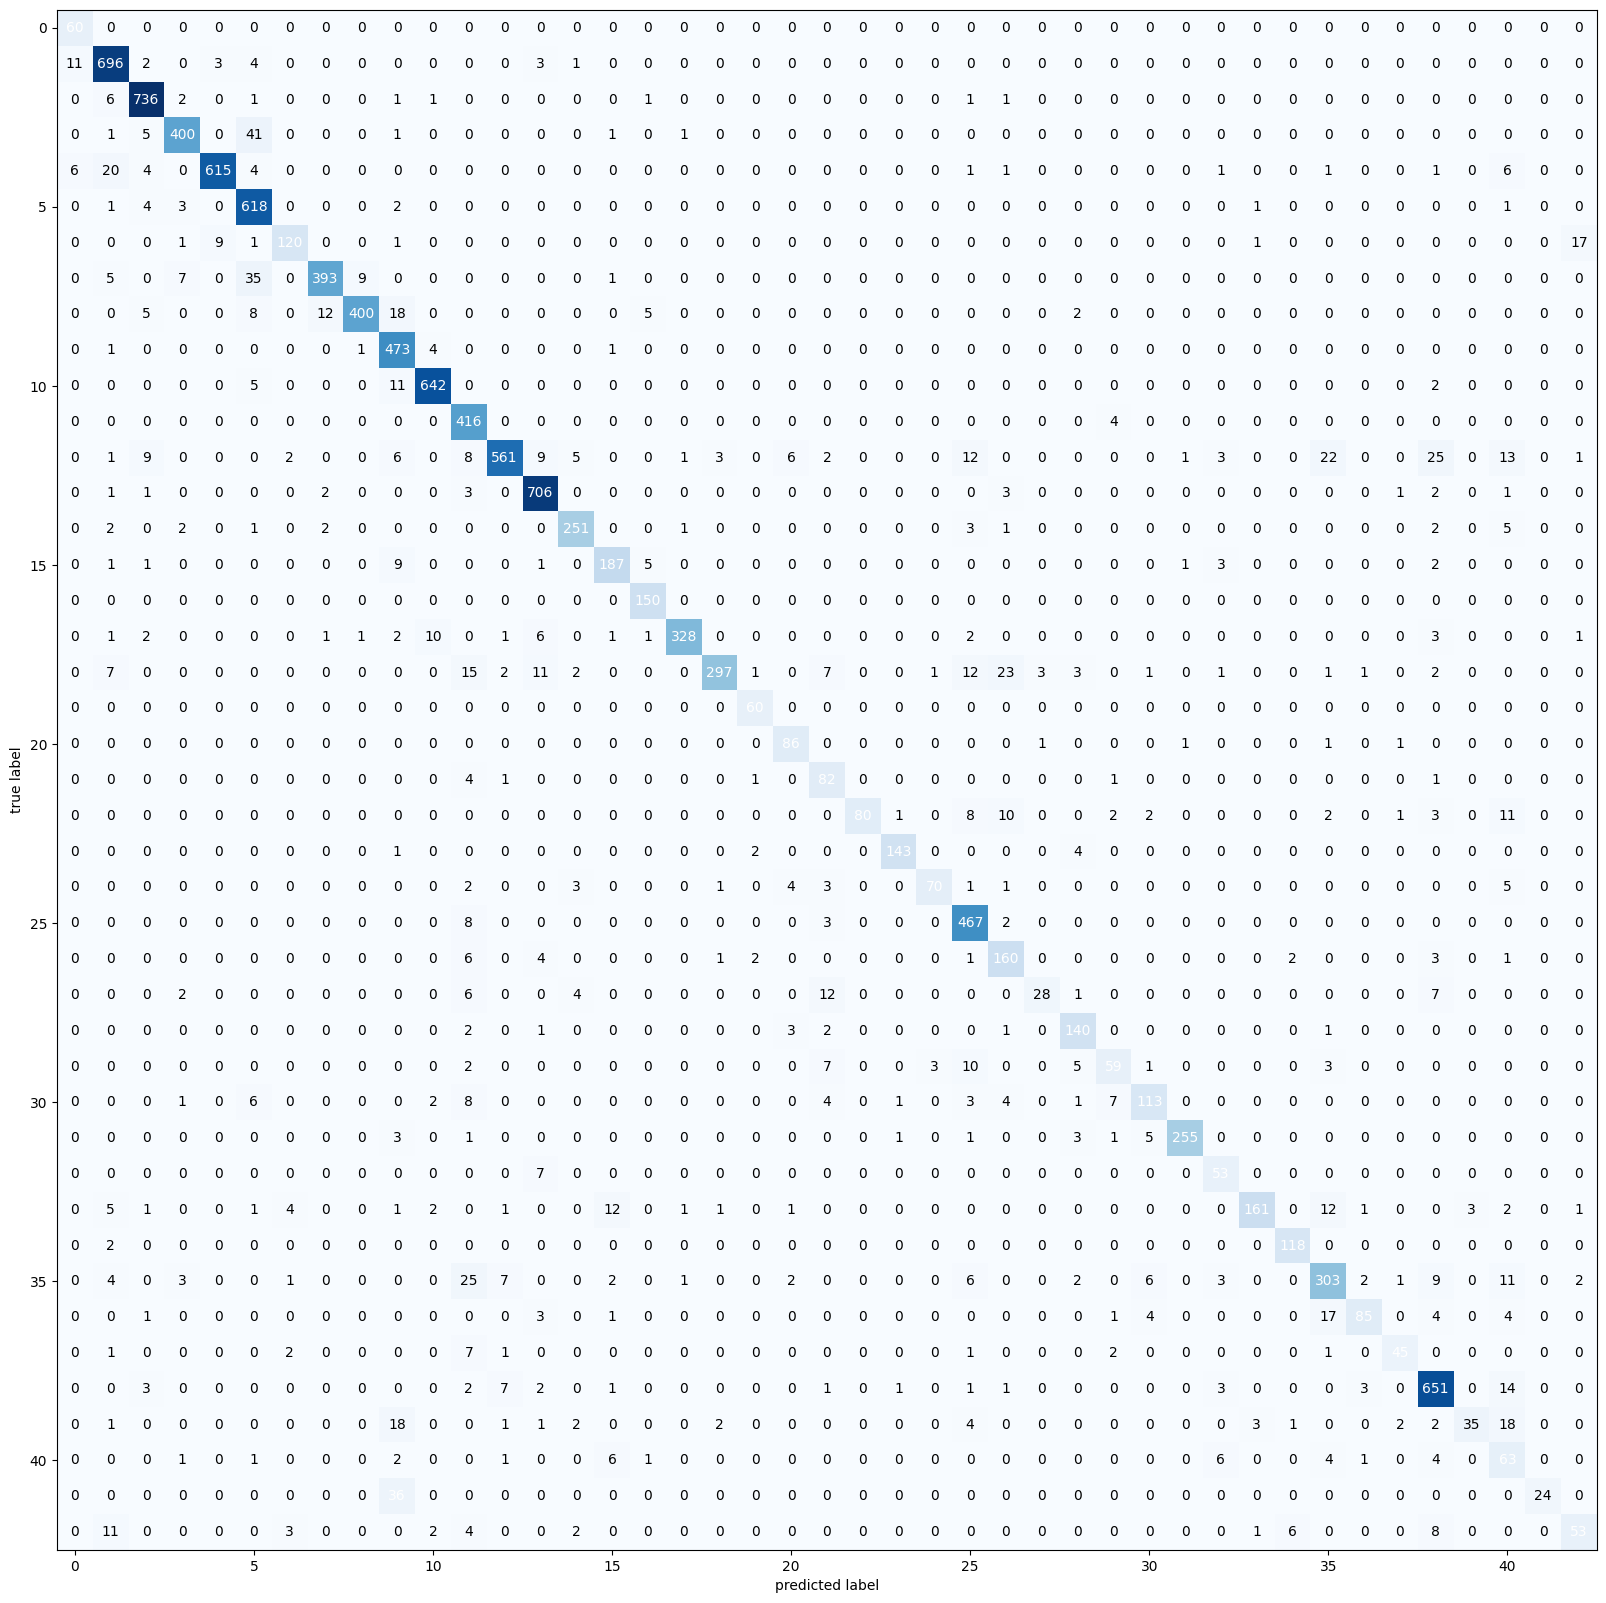

validation

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.91      1.00      0.95       240
           2       0.94      0.98      0.96       240
           3       0.99      0.97      0.98       150
           4       1.00      0.98      0.99       210
           5       0.88      0.99      0.93       210
           6       1.00      1.00      1.00        60
           7       0.99      0.92      0.96       150
           8       0.99      0.86      0.92       150
           9       0.87      0.99      0.92       150
          10       0.99      1.00      0.99       210
          11       0.79      1.00      0.88       150
          12       0.84      0.88      0.86       210
          13       0.96      0.99      0.97       240
          14       0.96      0.90      0.93        90
          15       0.96      0.91      0.94        90
          16       0.94      0.48      0.64  

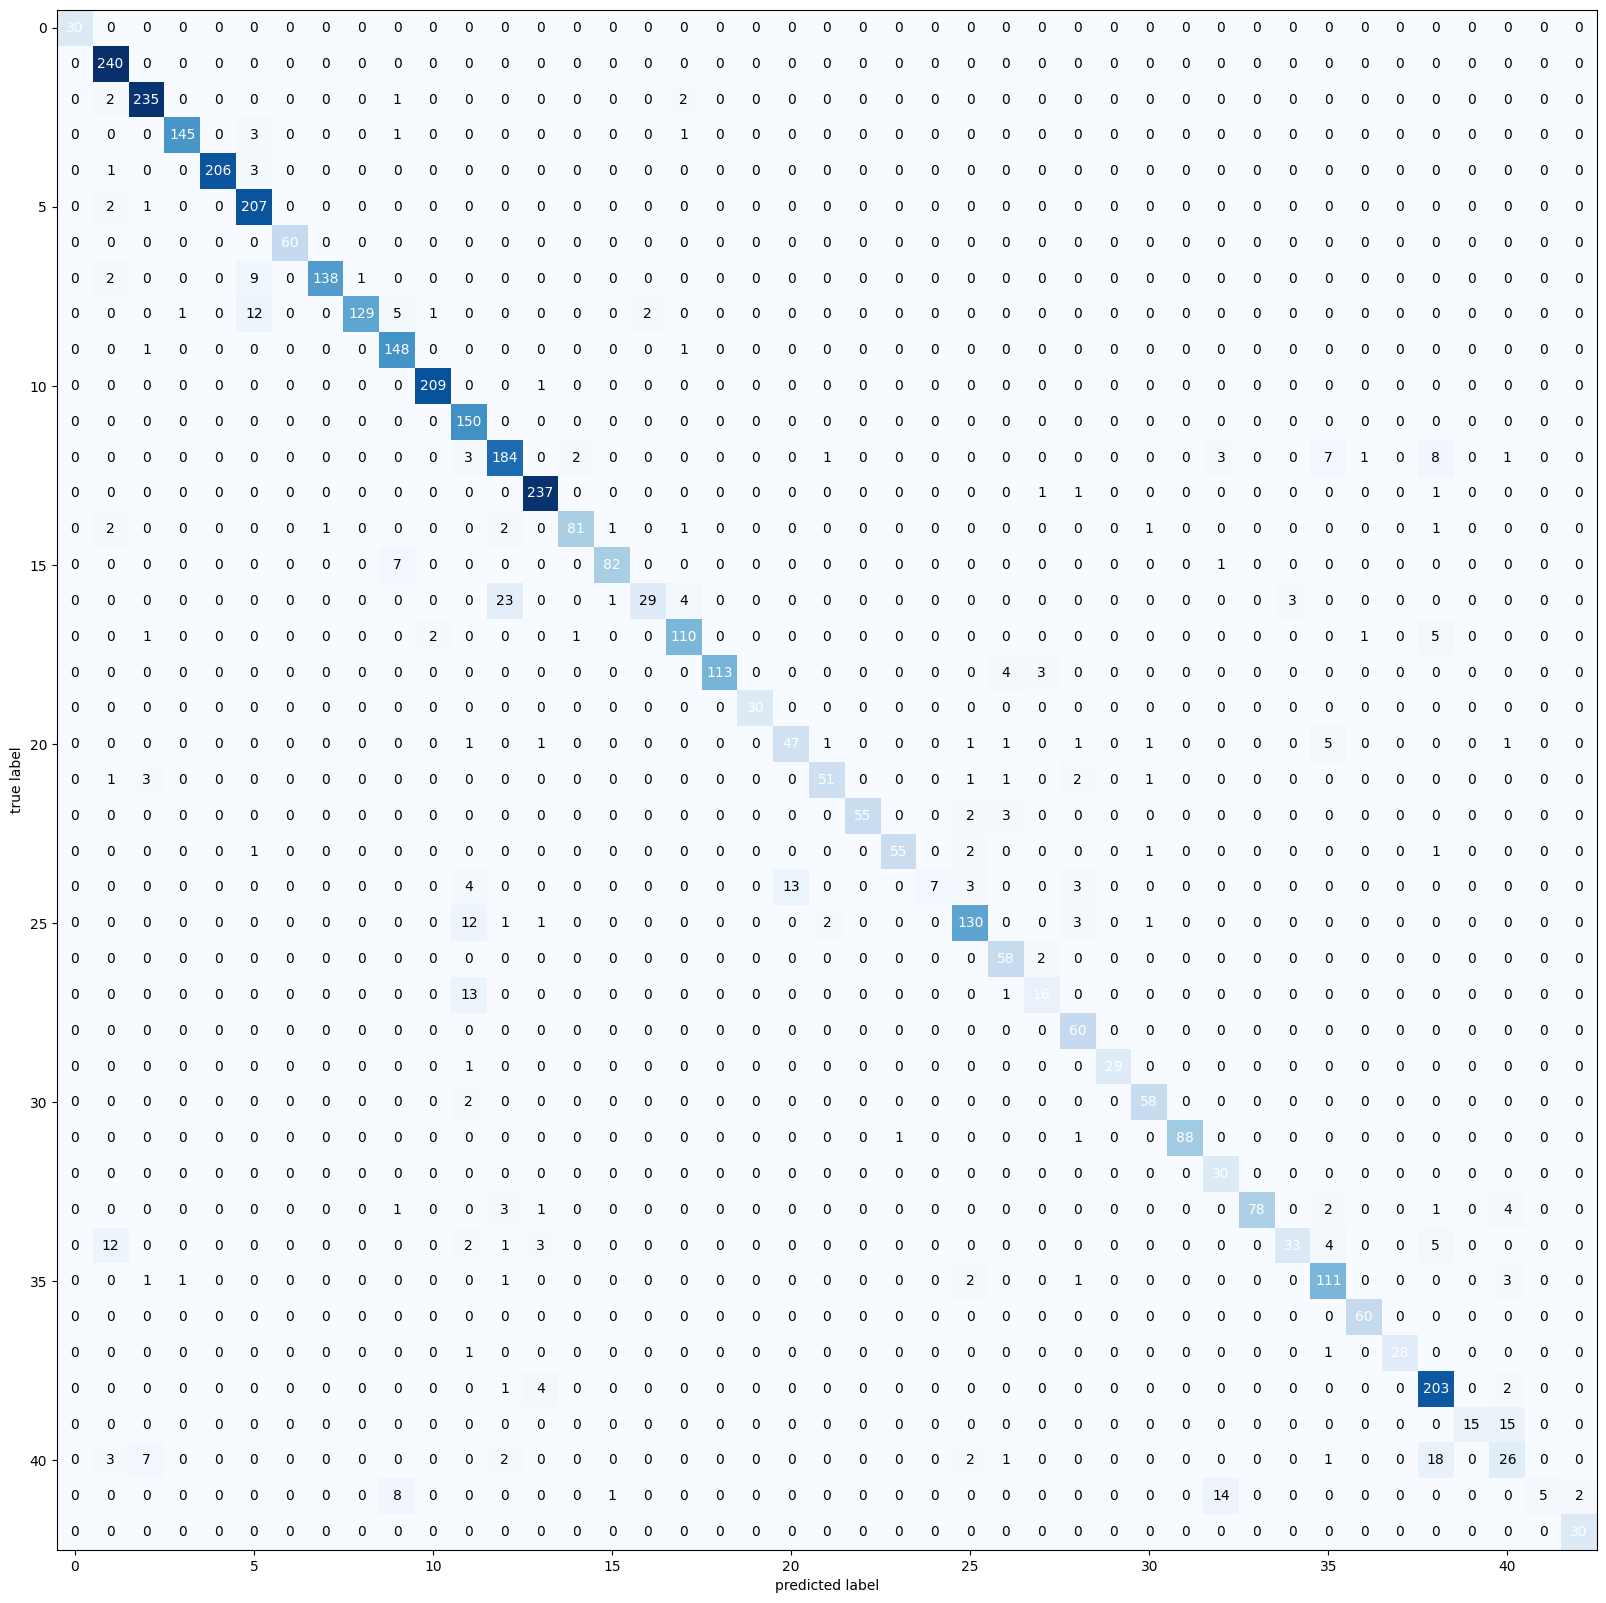

In [ ]:
def res(dataLoader):  
    trues = []
    preds = []
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(dataLoader):
            x = batch["x"]
            y = batch["y"]

            outputs = model(x)

            true_labels = torch.max(y, 1)[1]
            trues = trues + true_labels.tolist()
            pred_labels = torch.max(outputs, 1)[1]
            preds = preds + pred_labels.tolist()


    make_report(y_pred = preds, y_true = trues)

print('Test')
res(dataLoader_test)
print('validation')
res(dataLoader_validation)